<h1>MPST: Movie Plot Synopses with Tags</h1>


<h1>Business Problem</h1>


<h2>1.1 Dataset Description</h2>
<ul>
 <li>Abstract Social tagging of movies reveals a wide range of heterogeneous information about movies, like the genre, plot structure, soundtracks, metadata, visual and emotional experiences.</li>
 <li> Such information can be valuable in building automatic systems to create tags for movies.</li>
  <li> Automatic tagging systems can help recommendation engines to improve the retrieval of similar movies as well as help viewers to know what to expect from a movie in advance.</li>
 <li> In this paper, we set out to the task of collecting a corpus of movie plot synopses and tags. </li>
  <li>We describe a methodology that enabled us to build a fine-grained set of around 70 tags exposing heterogeneous characteristics of movie plots and the multi-label associations of these tags with some 14K movie plot synopses.</li>
 <li> We investigate how these tags correlate with movies and the flow of emotions throughout different types of movies. Finally, we use this corpus to explore the feasibility of inferring tags from plot synopses. </li>
 <li>We expect the corpus will be useful in other tasks where analysis of narratives is relevant</li>
</ul>

<h2>1.2 Data Source</h2>
<ul>
<li>
Dataset : https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags
</li>
<li>Please find the paper here: https://www.aclweb.org/anthology/L18-1274</li>
<li>This dataset was published in LREC 2018@Miyazaki, Japan.</li>
<li>Keywords Tag generation for movies, Movie plot analysis, Multi-label dataset, Narrative texts</li>
<li>More information is available here http://ritual.uh.edu/mpst-2018/</li>
</ul>

<h2> 1.3 Problem Statement</h2>
<ul>
<li>Identify which tag should be assigned to which movie.</li>
<li>we present the MPST corpus that contains plot synopses of 14,828 movies and their associations with a set of fine-grained tags, where each movie is tagged      with one or more tags.
</li>
</ul>

<h2>1.4 Real world/Business Objectives and Constraints</h2>
<ul>
<li>Predict as many tags as possible with high precision and recall.</li>
<li>No strict latency concerns.</li>
</ul>

<h2>2. Machine Learning Problem </h2>

<h2>2.1 Data Format</h2>


*   Data will be in a csv file
*   Train.csv contains 6 columns : imdb_id, title, plot_synopsis, tags, split, synopsis_source

*   Size of Train.csv - 28MB 
*   Number of rows in Train.csv = 14,828






<h2>2.2 Mapping the real-world problem to a Machine Learning Problem</h2>

<h2>2.2.1Type of Machine Learning Problem</h2>
<ul>
<li>It is a multi-label classification problem Multi-label Classification: Multilabel classification assigns to each sample a set of target labels.</li> <li>This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document.</li>
</ul>

<h2>2.2.2 Performance metric</h2>                             
<ul>
<li>
Micro-Averaged F1-Score (Mean F Score) : The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. <br>
The formula for the F1 score is: F1 = 2 * (precision * recall) / (precision +   recall)
</li>
<li>
In the multi-class and multi-label case, this is the weighted average of the F1 score of each class.
</li>
<li>
<b>' Micro f1 score ' : </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.</li>
<li>
<b>'Macro f1 score':</b> <br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
</li>
</ul>

<h2>3.Exploratory Data Analysis</h2>

<h2>3.1 Data Loading and Cleaning
</h2>

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from gensim import models
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
from scipy.sparse import coo_matrix, hstack 

In [0]:
df= pd.read_csv('drive/My Drive/colab/mpst_full_data.csv',sep=',') 

In [4]:
df.head(3)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb


In [5]:
print('No of rows and cols in data:',df.shape)

No of rows and cols in data: (14828, 6)


<h2> Checking NaN values </h2>

In [6]:
print('checking is there any nan values in data : ',df.isnull().any().any())
#there is no nan values in our data 

checking is there any nan values in data :  False


<h2>checking Duplicates </h2>

In [7]:
org_len=len(df) 
pure_df = df.drop_duplicates(['title','plot_synopsis','tags'])
pure_len = len(pure_df)
print('Duplicates in our data  :',org_len - pure_len)
print('Before removing duplicates in our data we have :',org_len,'rows')
print('After removing duplicates we have  :',pure_len,'rows')

Duplicates in our data  : 76
Before removing duplicates in our data we have : 14828 rows
After removing duplicates we have  : 14752 rows


<h2>Analysis of Tags</h2>

<h3> checking No of Tags per Movie </h3>

In [8]:
import warnings
warnings.filterwarnings("ignore")
pure_df["tags_count"] = pure_df["tags"].apply(lambda text: len(text.split(" ")))
pure_df.head(5) 

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,tags_count
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,5
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,1
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,1
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb,4
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb,10


<h3>Minimum and maximum and Average no of Tags per movie </h3>

In [9]:
print('Maximum no of tags per movie',max(pure_df['tags_count']))
print('Minimum no of tags per movie',min(pure_df['tags_count']))
print('Avg no of tags per movie:', ((sum(pure_df['tags_count'])*1.0)/len(pure_df['tags_count'])))

Maximum no of tags per movie 27
Minimum no of tags per movie 1
Avg no of tags per movie: 3.2586090021691976


Plotting visually no of tags per movies 

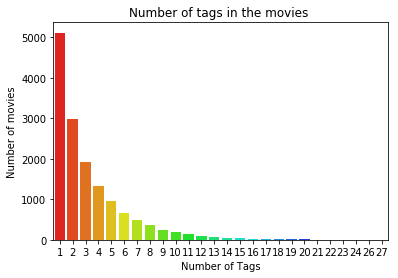

In [10]:
sns.countplot(pure_df['tags_count'], palette='gist_rainbow')
plt.title("Number of tags in the movies ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of movies")
plt.show()

Maximum no of tags per movie is 27 <br>
Minimum no of tags per movie is 1 <br>
Average no of tags per movie is 3 <br>
Most of the movies having tags 1 <br>
2,3 tags with movies tooks next place 

<h3> Unique No of tags </h3>

In [11]:
pure_df['tags_2'
] = pure_df['tags'].apply(lambda x : x.replace(' ', '').replace(',',' '))
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tags_vect = vectorizer.fit_transform(pure_df['tags_2'])
print("Number of data points :", tags_vect.shape[0])
print("Number of unique tags :", tags_vect.shape[1])

Number of data points : 14752
Number of unique tags : 71


In [12]:
tag_names = vectorizer.get_feature_names()
print("Some of the unique tags we have :", tag_names[:10])

Some of the unique tags we have : ['absurd', 'action', 'adultcomedy', 'allegory', 'alternatehistory', 'alternatereality', 'antiwar', 'atmospheric', 'autobiographical', 'avantgarde']


<h3> Number of times a movie tag apperead</h3>

In [13]:
freqs = tags_vect.sum(axis=0).A1
result = dict(zip(tag_names, freqs))
result

{'absurd': 270,
 'action': 659,
 'adultcomedy': 128,
 'allegory': 138,
 'alternatehistory': 102,
 'alternatereality': 205,
 'antiwar': 118,
 'atmospheric': 396,
 'autobiographical': 44,
 'avantgarde': 220,
 'blaxploitation': 74,
 'bleak': 211,
 'boring': 525,
 'brainwashing': 107,
 'christianfilm': 42,
 'claustrophobic': 84,
 'clever': 87,
 'comedy': 1858,
 'comic': 114,
 'cruelty': 442,
 'cult': 2647,
 'cute': 197,
 'dark': 405,
 'depressing': 205,
 'dramatic': 412,
 'entertaining': 749,
 'fantasy': 544,
 'feel-good': 76,
 'flashback': 2937,
 'goodversusevil': 874,
 'gothic': 441,
 'grindhousefilm': 66,
 'haunting': 149,
 'historical': 272,
 'historicalfiction': 139,
 'homemovie': 153,
 'horror': 485,
 'humor': 822,
 'insanity': 634,
 'inspiring': 118,
 'intrigue': 168,
 'magicalrealism': 54,
 'melodrama': 456,
 'murder': 5762,
 'mystery': 519,
 'neonoir': 745,
 'nonfiction': 37,
 'paranormal': 546,
 'philosophical': 228,
 'plottwist': 205,
 'pornographic': 163,
 'prank': 255,
 'psych

If we observe tags in above dictionary we got same tags with different counts its not duplicate there are some movies which contains same kind tags category or that tag belongs to one of movie sub category 

In [14]:
tags_counts = pd.DataFrame(result.items(),columns=['tags','counts'])
tags_sorted = tags_counts.sort_values(['counts'],ascending=False)
tags_sorted.head(3)

,tags,counts
43,murder,5762
68,violence,4420
28,flashback,2937


<h3> Most frequent tags </h3>

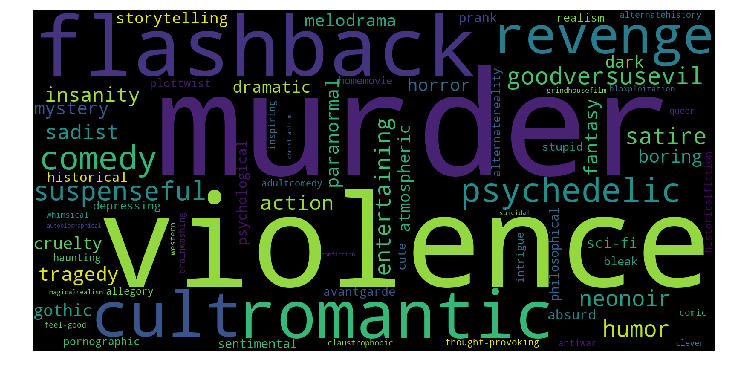

In [15]:
# Ploting word cloud
# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

If we observe above wordcloud most frequent 5 tags are **violance**, **murder**, **cult**, **revenge**, **flashback**

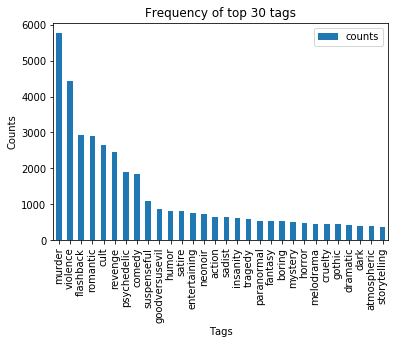

In [16]:
i=np.arange(30)
tags_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 30 tags')
plt.xticks(i, tags_sorted['tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

Most of the frequent movie tags are **Murder**, **violence**, **cult**, **flashback**, **romantic**, **revenge** <br>




<h2> Data Cleaning </h2>

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [21]:
pure_df.head(3)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,tags_count,tags_2
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,5,cult horror gothic murder atmospheric
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,1,violence
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,1,romantic


We considering only tile ,plot_synopsis, tags for modeling rest of feature are not much useful

In [20]:
pure_df['pre_pro_title'] = preprocess_text(pure_df['title'].values)
pure_df['pre_pro_plot_synopsis'] = preprocess_text(pure_df['plot_synopsis'].values) 

100%|██████████| 14752/14752 [00:29<00:00, 506.54it/s]


In [0]:
pure_df['pre_pro_tags'] = pure_df['tags'].apply(lambda x : x.replace(' ', '').replace(',',' '))

In [22]:
pure_df.head(3)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,tags_count,tags_2,pre_pro_title,pre_pro_plot_synopsis,pre_pro_tags
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,5,cult horror gothic murder atmospheric,tre volti della paura,note synopsis orginal italian release segments...,cult horror gothic murder atmospheric
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,1,violence,dungeons dragons book vile darkness,two thousand years ago nhagruul foul sorcerer ...,violence
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,1,romantic,shop around corner,matuschek gift store budapest workplace alfred...,romantic


<h3>Converting tags for multilabel problems</h3>

In [23]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(pure_df['pre_pro_tags'])
multilabel_y.shape 

(14752, 71)

<h3>Here we picking Top_3 and Top_5 tags out of 71 tags and applying different featurizations inspired from research paper 
 </h3>

1.   UNI_GRAMS
2.   BI_GRAMS
3.   TRI_GRAMS
4.   CHAR_GRAMS(3,4)
5.   UNI + BI + TRI
6.   CHAR_3 + CHAR_4
7.   UNI + BI + TRI + CHAR_3 + CHAR_4 





In [24]:
#top-3 tags 
#Refer above research paper we first analysis on top 3 tags 
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true',max_features=3)
multilabel_y3 = vectorizer.fit_transform(pure_df['pre_pro_tags'])
multilabel_y3.shape 

(14752, 3)

<h3>3_Tags Data</h2>

In [0]:
X = pure_df.drop(['pre_pro_tags'],axis=1) 
Y = multilabel_y3 

In [0]:
x_train_data, x_test_3, y_train_data, y_test_3 = train_test_split(X, Y, test_size=0.20, random_state=42) 

In [0]:
x_train_3, x_cv_3, y_train_3, y_cv_3 = train_test_split(x_train_data, y_train_data, test_size=0.20, random_state=42)

In [28]:
print('train_data shape',x_train_3.shape,y_train_3.shape)
print('train_data shape',x_cv_3.shape,y_cv_3.shape)
print('test_data shape',x_test_3.shape,y_test_3.shape)

train_data shape (9440, 10) (9440, 3)
train_data shape (2361, 10) (2361, 3)
test_data shape (2951, 10) (2951, 3)


<h2>Applying Bow Uni Grams on Top 3-Tags Data </h2>


In [29]:
%%time
vectorizer = CountVectorizer(min_df=10,max_features=10000)
xb_train_multilabel_3 = vectorizer.fit_transform(x_train_3['pre_pro_plot_synopsis'])
xb_cv_multilabel_3 = vectorizer.transform(x_cv_3['pre_pro_plot_synopsis'])
xb_test_multilabel_3 = vectorizer.transform(x_test_3['pre_pro_plot_synopsis'])

print('bow_train data',xb_train_multilabel_3.shape,y_train_3.shape)
print('bow_cv data',xb_cv_multilabel_3.shape,y_cv_3.shape)
print('bow_test data',xb_test_multilabel_3.shape,y_test_3.shape)

bow_train data (9440, 10000) (9440, 3)
bow_cv data (2361, 10000) (2361, 3)
bow_test data (2951, 10000) (2951, 3)
CPU times: user 5.36 s, sys: 60.6 ms, total: 5.42 s
Wall time: 5.42 s


<h2>Applying Bow Bi Grams on Top 3-Tags Data </h2>


In [30]:
%%time
vectorizer = CountVectorizer(ngram_range=(2,2),min_df=10,max_features=10000)
xb2_train_multilabel_3 = vectorizer.fit_transform(x_train_3['pre_pro_plot_synopsis'])
xb2_cv_multilabel_3 = vectorizer.transform(x_cv_3['pre_pro_plot_synopsis'])
xb2_test_multilabel_3 = vectorizer.transform(x_test_3['pre_pro_plot_synopsis'])

print('bow_train data',xb2_train_multilabel_3.shape,y_train_3.shape)
print('bow_cv data',xb2_cv_multilabel_3.shape,y_cv_3.shape)
print('bow_test data',xb2_test_multilabel_3.shape,y_test_3.shape)

bow_train data (9440, 10000) (9440, 3)
bow_cv data (2361, 10000) (2361, 3)
bow_test data (2951, 10000) (2951, 3)
CPU times: user 23.2 s, sys: 629 ms, total: 23.8 s
Wall time: 23.8 s


<h2>Applying Bow Tri Grams on Top 3-Tags Data </h2>



In [31]:
%%time
vectorizer = CountVectorizer(ngram_range=(3,3),min_df=10,max_features=10000)
xb3_train_multilabel_3 = vectorizer.fit_transform(x_train_3['pre_pro_plot_synopsis'])
xb3_cv_multilabel_3 = vectorizer.transform(x_cv_3['pre_pro_plot_synopsis'])
xb3_test_multilabel_3 = vectorizer.transform(x_test_3['pre_pro_plot_synopsis'])

print('bow_train data',xb3_train_multilabel_3.shape,y_train_3.shape)
print('bow_cv data',xb3_cv_multilabel_3.shape,y_cv_3.shape)
print('bow_test data',xb3_test_multilabel_3.shape,y_test_3.shape)

bow_train data (9440, 987) (9440, 3)
bow_cv data (2361, 987) (2361, 3)
bow_test data (2951, 987) (2951, 3)
CPU times: user 30.1 s, sys: 584 ms, total: 30.7 s
Wall time: 30.7 s


<h2>Applying Bow Char 3 Grams on Top 3-Tags Data </h2>


In [32]:
%%time
vectorizer = CountVectorizer(ngram_range=(3,3),analyzer='char',min_df=10,max_features=10000)
xbc_train_multilabel_3 = vectorizer.fit_transform(x_train_3['pre_pro_plot_synopsis'])
xbc_cv_multilabel_3 = vectorizer.transform(x_cv_3['pre_pro_plot_synopsis'])
xbc_test_multilabel_3 = vectorizer.transform(x_test_3['pre_pro_plot_synopsis'])

print('bow_train data',xbc_train_multilabel_3.shape,y_train_3.shape)
print('bow_cv data',xbc_cv_multilabel_3.shape,y_cv_3.shape)
print('bow_test data',xbc_test_multilabel_3.shape,y_test_3.shape)

bow_train data (9440, 8046) (9440, 3)
bow_cv data (2361, 8046) (2361, 3)
bow_test data (2951, 8046) (2951, 3)
CPU times: user 24.7 s, sys: 51.6 ms, total: 24.8 s
Wall time: 24.8 s


<h2>Applying Bow Char 4  Grams on Top 3-Tags Data </h2>


In [33]:
%%time
vectorizer = CountVectorizer(ngram_range=(4,4),analyzer='char',min_df=10,max_features=10000)
xbs_train_multilabel_3 = vectorizer.fit_transform(x_train_3['pre_pro_plot_synopsis'])
xbs_cv_multilabel_3 = vectorizer.transform(x_cv_3['pre_pro_plot_synopsis'])
xbs_test_multilabel_3 = vectorizer.transform(x_test_3['pre_pro_plot_synopsis'])

print('bow_train data',xbs_train_multilabel_3.shape,y_train_3.shape)
print('bow_cv data',xbs_cv_multilabel_3.shape,y_cv_3.shape)
print('bow_test data',xbs_test_multilabel_3.shape,y_test_3.shape)

bow_train data (9440, 10000) (9440, 3)
bow_cv data (2361, 10000) (2361, 3)
bow_test data (2951, 10000) (2951, 3)
CPU times: user 29.4 s, sys: 37.9 ms, total: 29.4 s
Wall time: 29.4 s


<h3>BOW UNI + BI + TRI grams</h3> 

In [0]:
bow_tr_uni_bi_3 = hstack((xb_train_multilabel_3,xb2_train_multilabel_3),format='csr',dtype='float64')
bow_cv_uni_bi_3 = hstack((xb_cv_multilabel_3,xb2_cv_multilabel_3),format='csr',dtype='float64')
bow_te_uni_bi_3 = hstack((xb_test_multilabel_3,xb2_test_multilabel_3),format='csr',dtype='float64')

bow_tr_uni_bi_tri_3 = hstack((bow_tr_uni_bi_3,xb3_train_multilabel_3),format='csr',dtype='float64')
bow_cv_uni_bi_tri_3 = hstack((bow_cv_uni_bi_3,xb3_cv_multilabel_3),format='csr',dtype='float64')
bow_te_uni_bi_tri_3 = hstack((bow_te_uni_bi_3,xb3_test_multilabel_3),format='csr',dtype='float64')

<h3>BOw Char 3 + Char 4 Grams </h3>

In [0]:
bow_tr_c3_c4_3 = hstack((xbc_train_multilabel_3,xbs_train_multilabel_3),format='csr',dtype='float64')
bow_cv_c3_c4_3 = hstack((xbc_cv_multilabel_3,xbs_cv_multilabel_3),format='csr',dtype='float64')
bow_te_c3_c4_3 = hstack((xbc_test_multilabel_3,xbs_test_multilabel_3),format='csr',dtype='float64') 

<h3>Bow UNI + BI + TRI + C3 + C4 Grams</h3>

In [0]:
bow_tr_u_b_t_c3_c4_3 = hstack((bow_tr_uni_bi_tri_3,bow_tr_c3_c4_3),format='csr',dtype='float64') 
bow_cv_u_b_t_c3_c4_3 = hstack((bow_cv_uni_bi_tri_3,bow_cv_c3_c4_3),format='csr',dtype='float64') 
bow_te_u_b_t_c3_c4_3 = hstack((bow_te_uni_bi_tri_3,bow_te_c3_c4_3),format='csr',dtype='float64') 

<h3> BOW 5_Tags Data</h3>

In [37]:
#top-5 tags 
#Refer above research paper we second we analysis on top 5 tags 
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true',max_features=5)
multilabel_y5 = vectorizer.fit_transform(pure_df['pre_pro_tags'])
multilabel_y5.shape 

(14752, 5)

In [0]:
X2 = pure_df.drop(['pre_pro_tags'],axis=1) 
Y2 = multilabel_y5 

In [39]:
#test data 
x_train_data, x_test_5, y_train_data, y_test_5 = train_test_split(X2, Y2, test_size=0.20, random_state=42) 
#Train and  CV
x_train_5, x_cv_5, y_train_5, y_cv_5 = train_test_split(x_train_data, y_train_data, test_size=0.20, random_state=42)

print('train_data shape',x_train_5.shape,y_train_5.shape)
print('train_data shape',x_cv_5.shape,y_cv_5.shape)
print('test_data shape',x_test_5.shape,y_test_5.shape)

train_data shape (9440, 10) (9440, 5)
train_data shape (2361, 10) (2361, 5)
test_data shape (2951, 10) (2951, 5)


<h2>Applying Bow Uni Grams on 5-Tags Data </h2>


In [40]:
%%time
vectorizer = CountVectorizer(min_df=10,max_features=10000)
xb_train_multilabel_5 = vectorizer.fit_transform(x_train_5['pre_pro_plot_synopsis'])
xb_cv_multilabel_5 = vectorizer.transform(x_cv_5['pre_pro_plot_synopsis'])
xb_test_multilabel_5 = vectorizer.transform(x_test_5['pre_pro_plot_synopsis'])

print('bow_train data',xb_train_multilabel_5.shape,y_train_5.shape)
print('bow_cv data',xb_cv_multilabel_5.shape,y_cv_5.shape)
print('bow_test data',xb_test_multilabel_5.shape,y_test_5.shape)

bow_train data (9440, 10000) (9440, 5)
bow_cv data (2361, 10000) (2361, 5)
bow_test data (2951, 10000) (2951, 5)
CPU times: user 5.34 s, sys: 16.9 ms, total: 5.36 s
Wall time: 5.36 s


<h2>Applying Bow Bi Grams on 5-Tags Data </h2>

In [0]:
%%time
vectorizer = CountVectorizer(ngram_range=(2,2),min_df=10,max_features=10000)
xb2_train_multilabel_5 = vectorizer.fit_transform(x_train_5['pre_pro_plot_synopsis'])
xb2_cv_multilabel_5 = vectorizer.transform(x_cv_5['pre_pro_plot_synopsis'])
xb2_test_multilabel_5 = vectorizer.transform(x_test_5['pre_pro_plot_synopsis'])

print('bow_train data',xb2_train_multilabel_5.shape,y_train_5.shape)
print('bow_cv data',xb2_cv_multilabel_5.shape,y_cv_5.shape)
print('bow_test data',xb2_test_multilabel_5.shape,y_test_5.shape)

<h2>Applying Bow Tri Grams on 5-Tags Data </h2>

In [42]:
%%time
vectorizer = CountVectorizer(ngram_range=(3,3),min_df=10,max_features=10000)
xb3_train_multilabel_5 = vectorizer.fit_transform(x_train_5['pre_pro_plot_synopsis'])
xb3_cv_multilabel_5 = vectorizer.transform(x_cv_5['pre_pro_plot_synopsis'])
xb3_test_multilabel_5 = vectorizer.transform(x_test_5['pre_pro_plot_synopsis'])

print('bow_train data',xb3_train_multilabel_5.shape,y_train_5.shape)
print('bow_cv data',xb3_cv_multilabel_5.shape,y_cv_5.shape)
print('bow_test data',xb3_test_multilabel_5.shape,y_test_5.shape)

bow_train data (9440, 987) (9440, 5)
bow_cv data (2361, 987) (2361, 5)
bow_test data (2951, 987) (2951, 5)
CPU times: user 28.8 s, sys: 492 ms, total: 29.3 s
Wall time: 29.4 s


<h2>Applying Bow Char 3 Grams on 5-Tags Data </h2>

In [43]:
%%time
vectorizer = CountVectorizer(ngram_range=(3,3),analyzer='char',min_df=10,max_features=10000)
xbc_train_multilabel_5 = vectorizer.fit_transform(x_train_5['pre_pro_plot_synopsis'])
xbc_cv_multilabel_5 = vectorizer.transform(x_cv_5['pre_pro_plot_synopsis'])
xbc_test_multilabel_5 = vectorizer.transform(x_test_5['pre_pro_plot_synopsis'])

print('bow_train data',xbc_train_multilabel_5.shape,y_train_5.shape)
print('bow_cv data',xbc_cv_multilabel_5.shape,y_cv_5.shape)
print('bow_test data',xbc_test_multilabel_5.shape,y_test_5.shape)

bow_train data (9440, 8046) (9440, 5)
bow_cv data (2361, 8046) (2361, 5)
bow_test data (2951, 8046) (2951, 5)
CPU times: user 24.8 s, sys: 36.5 ms, total: 24.9 s
Wall time: 24.9 s


<h2>Applying Bow Char 4 Grams on 5-Tags Data </h2>

In [44]:
%%time
vectorizer = CountVectorizer(ngram_range=(4,4),analyzer='char',min_df=10,max_features=10000)
xbs_train_multilabel_5 = vectorizer.fit_transform(x_train_5['pre_pro_plot_synopsis'])
xbs_cv_multilabel_5 = vectorizer.transform(x_cv_5['pre_pro_plot_synopsis'])
xbs_test_multilabel_5 = vectorizer.transform(x_test_5['pre_pro_plot_synopsis'])

print('bow_train data',xbs_train_multilabel_5.shape,y_train_5.shape)
print('bow_cv data',xbs_cv_multilabel_5.shape,y_cv_5.shape)
print('bow_test data',xbs_test_multilabel_5.shape,y_test_5.shape)

bow_train data (9440, 10000) (9440, 5)
bow_cv data (2361, 10000) (2361, 5)
bow_test data (2951, 10000) (2951, 5)
CPU times: user 29.5 s, sys: 26.4 ms, total: 29.5 s
Wall time: 29.5 s


<h3>BOW_5 UNI + BI + TRI </h3>

In [0]:
bow_tr_uni_bi_5 = hstack((xb_train_multilabel_5,xb2_train_multilabel_5),format='csr',dtype='float64')
bow_cv_uni_bi_5 = hstack((xb_cv_multilabel_5,xb2_cv_multilabel_5),format='csr',dtype='float64')
bow_te_uni_bi_5 = hstack((xb_test_multilabel_5,xb2_test_multilabel_5),format='csr',dtype='float64')

bow_tr_uni_bi_tri_5 = hstack((bow_tr_uni_bi_5,xb3_train_multilabel_5),format='csr',dtype='float64')
bow_cv_uni_bi_tri_5 = hstack((bow_cv_uni_bi_5,xb3_cv_multilabel_5),format='csr',dtype='float64')
bow_te_uni_bi_tri_5 = hstack((bow_te_uni_bi_5,xb3_test_multilabel_5),format='csr',dtype='float64')

<h3> BOW_5 C3 + C4 </h3>

In [0]:
bow_tr_c3_c4_5 = hstack((xbc_train_multilabel_5,xbs_train_multilabel_5),format='csr',dtype='float64')
bow_cv_c3_c4_5 = hstack((xbc_cv_multilabel_5,xbs_cv_multilabel_5),format='csr',dtype='float64')
bow_te_c3_c4_5 = hstack((xbc_test_multilabel_5,xbs_test_multilabel_5),format='csr',dtype='float64') 

<h3> BOW_5 UNI + BI + TRI + C3 + C4 </h3>

In [0]:
bow_tr_u_b_t_c3_c4_5 = hstack((bow_tr_uni_bi_tri_5,bow_tr_c3_c4_5),format='csr',dtype='float64') 
bow_cv_u_b_t_c3_c4_5 = hstack((bow_cv_uni_bi_tri_5,bow_cv_c3_c4_5),format='csr',dtype='float64') 
bow_te_u_b_t_c3_c4_5 = hstack((bow_te_uni_bi_tri_5,bow_te_c3_c4_5),format='csr',dtype='float64') 

<h2>Applying TFIDF vectorizer on 3-Tag data </h2>

In [48]:
%%time
tf_idf_vect  = TfidfVectorizer(max_features=10000)
xt_train_multilabel_3 = tf_idf_vect.fit_transform(x_train_3['pre_pro_plot_synopsis'])
xt_cv_multilabel_3 = tf_idf_vect.transform(x_cv_3['pre_pro_plot_synopsis'])
xt_test_multilabel_3 = tf_idf_vect.transform(x_test_3['pre_pro_plot_synopsis'])
print('tfidf_train data',xt_train_multilabel_3.shape,y_train_3.shape)
print('tfidf_cv data',xt_cv_multilabel_3.shape,y_cv_3.shape) 
print('tfidf_test data',xt_test_multilabel_3.shape,y_test_3.shape) 

tfidf_train data (9440, 10000) (9440, 3)
tfidf_cv data (2361, 10000) (2361, 3)
tfidf_test data (2951, 10000) (2951, 3)
CPU times: user 5.5 s, sys: 12.9 ms, total: 5.52 s
Wall time: 5.53 s


<h2>Applying TFIDF vectorizer Bi grams on 3-Tag data </h2>

In [49]:

%%time
tf_idf_vect  = TfidfVectorizer(ngram_range=(2,2),max_features=10000)
xtb_train_multilabel_3 = tf_idf_vect.fit_transform(x_train_3['pre_pro_plot_synopsis'])
xtb_cv_multilabel_3 = tf_idf_vect.transform(x_cv_3['pre_pro_plot_synopsis'])
xtb_test_multilabel_3 = tf_idf_vect.transform(x_test_3['pre_pro_plot_synopsis'])
print('tfidf_train data',xtb_train_multilabel_3.shape,y_train_3.shape)
print('tfidf_cv data',xtb_cv_multilabel_3.shape,y_cv_3.shape) 
print('tfidf_test data',xtb_test_multilabel_3.shape,y_test_3.shape) 

tfidf_train data (9440, 10000) (9440, 3)
tfidf_cv data (2361, 10000) (2361, 3)
tfidf_test data (2951, 10000) (2951, 3)
CPU times: user 22.5 s, sys: 315 ms, total: 22.8 s
Wall time: 22.8 s


<h2>Applying TFIDF vectorizer Tri grams on 3-Tag data </h2>

In [50]:
%%time
tf_idf_vect  = TfidfVectorizer(ngram_range=(3,3),max_features=10000)
xtt_train_multilabel_3 = tf_idf_vect.fit_transform(x_train_3['pre_pro_plot_synopsis'])
xtt_cv_multilabel_3 = tf_idf_vect.transform(x_cv_3['pre_pro_plot_synopsis'])
xtt_test_multilabel_3 = tf_idf_vect.transform(x_test_3['pre_pro_plot_synopsis'])
print('tfidf_train data',xtt_train_multilabel_3.shape,y_train_3.shape)
print('tfidf_cv data',xtt_cv_multilabel_3.shape,y_cv_3.shape) 
print('tfidf_test data',xtt_test_multilabel_3.shape,y_test_3.shape) 

tfidf_train data (9440, 10000) (9440, 3)
tfidf_cv data (2361, 10000) (2361, 3)
tfidf_test data (2951, 10000) (2951, 3)
CPU times: user 29.2 s, sys: 489 ms, total: 29.7 s
Wall time: 29.7 s


<h2>Applying TFIDF vectorizer char 3  grams on 3-Tag data </h2>

In [51]:
%%time
tf_idf_vect  = TfidfVectorizer(ngram_range=(3,3),analyzer='char',max_features=10000)
xtc_train_multilabel_3 = tf_idf_vect.fit_transform(x_train_3['pre_pro_plot_synopsis'])
xtc_cv_multilabel_3 = tf_idf_vect.transform(x_cv_3['pre_pro_plot_synopsis'])
xtc_test_multilabel_3 = tf_idf_vect.transform(x_test_3['pre_pro_plot_synopsis'])
print('tfidf_train data',xtc_train_multilabel_3.shape,y_train_3.shape)
print('tfidf_cv data',xtc_cv_multilabel_3.shape,y_cv_3.shape) 
print('tfidf_test data',xtc_test_multilabel_3.shape,y_test_3.shape) 

tfidf_train data (9440, 10000) (9440, 3)
tfidf_cv data (2361, 10000) (2361, 3)
tfidf_test data (2951, 10000) (2951, 3)
CPU times: user 25.3 s, sys: 36.8 ms, total: 25.3 s
Wall time: 25.3 s


<h2>Applying TFIDF vectorizer char 4 grams on 3-Tag data </h2>

In [52]:
%%time
tf_idf_vect  = TfidfVectorizer(ngram_range=(4,4),analyzer='char',max_features=10000)
xts_train_multilabel_3 = tf_idf_vect.fit_transform(x_train_3['pre_pro_plot_synopsis'])
xts_cv_multilabel_3 = tf_idf_vect.transform(x_cv_3['pre_pro_plot_synopsis'])
xts_test_multilabel_3 = tf_idf_vect.transform(x_test_3['pre_pro_plot_synopsis'])
print('tfidf_train data',xts_train_multilabel_3.shape,y_train_3.shape)
print('tfidf_cv data',xts_cv_multilabel_3.shape,y_cv_3.shape) 
print('tfidf_test data',xts_test_multilabel_3.shape,y_test_3.shape) 

tfidf_train data (9440, 10000) (9440, 3)
tfidf_cv data (2361, 10000) (2361, 3)
tfidf_test data (2951, 10000) (2951, 3)
CPU times: user 30.1 s, sys: 22.8 ms, total: 30.1 s
Wall time: 30.2 s


<h3> TFIDF_3 UNI + BI + TRi </h3>

In [0]:
tf_tr_uni_bi_3 = hstack((xt_train_multilabel_3,xtb_train_multilabel_3),format='csr',dtype='float64')
tf_cv_uni_bi_3 = hstack((xt_cv_multilabel_3,xtb_cv_multilabel_3),format='csr',dtype='float64')
tf_te_uni_bi_3 = hstack((xt_test_multilabel_3,xtb_test_multilabel_3),format='csr',dtype='float64')

tf_tr_uni_bi_tri_3 = hstack((tf_tr_uni_bi_3,xtt_train_multilabel_3),format='csr',dtype='float64')
tf_cv_uni_bi_tri_3 = hstack((tf_cv_uni_bi_3,xtt_cv_multilabel_3),format='csr',dtype='float64')
tf_te_uni_bi_tri_3 = hstack((tf_te_uni_bi_3,xtt_test_multilabel_3),format='csr',dtype='float64')

<h3> TFIDF_3 C3 + C4 </h3>

In [0]:
tf_tr_c3_c4_3 = hstack((xtc_train_multilabel_3,xts_train_multilabel_3),format='csr',dtype='float64')
tf_cv_c3_c4_3 = hstack((xtc_cv_multilabel_3,xts_cv_multilabel_3),format='csr',dtype='float64')
tf_te_c3_c4_3 = hstack((xtc_test_multilabel_3,xts_test_multilabel_3),format='csr',dtype='float64') 

<h3> TFIDF_3 UNI + BI + TRi + C3 + C4 </h3>

In [0]:
tf_tr_u_b_t_c3_c4_3 = hstack((tf_tr_uni_bi_tri_3,tf_tr_c3_c4_3),format='csr',dtype='float64') 
tf_cv_u_b_t_c3_c4_3 = hstack((tf_cv_uni_bi_tri_3,tf_cv_c3_c4_3),format='csr',dtype='float64') 
tf_te_u_b_t_c3_c4_3 = hstack((tf_te_uni_bi_tri_3,tf_te_c3_c4_3),format='csr',dtype='float64') 

<h2>Applying TFIDF vectorizer on 5-Tag data </h2>

In [56]:
%%time
tf_idf_vect  = TfidfVectorizer(max_features=10000)
xt_train_multilabel_5 = tf_idf_vect.fit_transform(x_train_5['pre_pro_plot_synopsis'])
xt_cv_multilabel_5 = tf_idf_vect.transform(x_cv_5['pre_pro_plot_synopsis'])
xt_test_multilabel_5 = tf_idf_vect.transform(x_test_5['pre_pro_plot_synopsis'])
print('tfidf_train data',xt_train_multilabel_5.shape,y_train_5.shape)
print('tfidf_cv data',xt_cv_multilabel_5.shape,y_cv_5.shape) 
print('tfidf_test data',xt_test_multilabel_5.shape,y_test_5.shape) 

tfidf_train data (9440, 10000) (9440, 5)
tfidf_cv data (2361, 10000) (2361, 5)
tfidf_test data (2951, 10000) (2951, 5)
CPU times: user 5.45 s, sys: 19 ms, total: 5.46 s
Wall time: 5.47 s


<h2>Applying TFIDF vectorizer Bi grams on 5-Tag data </h2>

In [57]:
%%time
tf_idf_vect  = TfidfVectorizer(ngram_range=(2,2),max_features=10000)
xtb_train_multilabel_5 = tf_idf_vect.fit_transform(x_train_5['pre_pro_plot_synopsis'])
xtb_cv_multilabel_5 = tf_idf_vect.transform(x_cv_5['pre_pro_plot_synopsis'])
xtb_test_multilabel_5 = tf_idf_vect.transform(x_test_5['pre_pro_plot_synopsis'])
print('tfidf_train data',xtb_train_multilabel_5.shape,y_train_5.shape)
print('tfidf_cv data',xtb_cv_multilabel_5.shape,y_cv_5.shape) 
print('tfidf_test data',xtb_test_multilabel_5.shape,y_test_5.shape) 

tfidf_train data (9440, 10000) (9440, 5)
tfidf_cv data (2361, 10000) (2361, 5)
tfidf_test data (2951, 10000) (2951, 5)
CPU times: user 22.5 s, sys: 320 ms, total: 22.8 s
Wall time: 22.8 s


<h2>Applying TFIDF vectorizer Tri grams on 5-Tag data </h2>

In [58]:
%%time
tf_idf_vect  = TfidfVectorizer(ngram_range=(3,3),max_features=10000)
xtt_train_multilabel_5 = tf_idf_vect.fit_transform(x_train_5['pre_pro_plot_synopsis'])
xtt_cv_multilabel_5 = tf_idf_vect.transform(x_cv_5['pre_pro_plot_synopsis'])
xtt_test_multilabel_5 = tf_idf_vect.transform(x_test_5['pre_pro_plot_synopsis'])
print('tfidf_train data',xtt_train_multilabel_5.shape,y_train_5.shape)
print('tfidf_cv data',xtt_cv_multilabel_5.shape,y_cv_5.shape) 
print('tfidf_test data',xtt_test_multilabel_5.shape,y_test_5.shape) 

tfidf_train data (9440, 10000) (9440, 5)
tfidf_cv data (2361, 10000) (2361, 5)
tfidf_test data (2951, 10000) (2951, 5)
CPU times: user 28.9 s, sys: 470 ms, total: 29.4 s
Wall time: 29.4 s


<h2>Applying TFIDF vectorizer char 3 grams on 5-Tag data </h2>

In [59]:
%%time
tf_idf_vect  = TfidfVectorizer(ngram_range=(3,3),analyzer='char',max_features=10000)
xtc_train_multilabel_5 = tf_idf_vect.fit_transform(x_train_5['pre_pro_plot_synopsis'])
xtc_cv_multilabel_5 = tf_idf_vect.transform(x_cv_5['pre_pro_plot_synopsis'])
xtc_test_multilabel_5 = tf_idf_vect.transform(x_test_5['pre_pro_plot_synopsis'])
print('tfidf_train data',xtc_train_multilabel_5.shape,y_train_5.shape)
print('tfidf_cv data',xtc_cv_multilabel_5.shape,y_cv_5.shape) 
print('tfidf_test data',xtc_test_multilabel_5.shape,y_test_5.shape) 

tfidf_train data (9440, 10000) (9440, 5)
tfidf_cv data (2361, 10000) (2361, 5)
tfidf_test data (2951, 10000) (2951, 5)
CPU times: user 25.1 s, sys: 34.8 ms, total: 25.1 s
Wall time: 25.1 s


<h2>Applying TFIDF vectorizer Char 4 grams on 5-Tag data </h2>

In [60]:
%%time
tf_idf_vect  = TfidfVectorizer(ngram_range=(4,4),analyzer='char',max_features=10000)
xts_train_multilabel_5 = tf_idf_vect.fit_transform(x_train_5['pre_pro_plot_synopsis'])
xts_cv_multilabel_5 = tf_idf_vect.transform(x_cv_5['pre_pro_plot_synopsis'])
xts_test_multilabel_5 = tf_idf_vect.transform(x_test_5['pre_pro_plot_synopsis'])
print('tfidf_train data',xts_train_multilabel_5.shape,y_train_5.shape)
print('tfidf_cv data',xts_cv_multilabel_5.shape,y_cv_5.shape) 
print('tfidf_test data',xts_test_multilabel_5.shape,y_test_5.shape) 

tfidf_train data (9440, 10000) (9440, 5)
tfidf_cv data (2361, 10000) (2361, 5)
tfidf_test data (2951, 10000) (2951, 5)
CPU times: user 29.8 s, sys: 25.8 ms, total: 29.8 s
Wall time: 29.8 s


<h3> TFIDF_5 UNI + BI + TRi </h3>

In [0]:
tf_tr_uni_bi_5 = hstack((xt_train_multilabel_5,xtb_train_multilabel_5),format='csr',dtype='float64')
tf_cv_uni_bi_5 = hstack((xt_cv_multilabel_5,xtb_cv_multilabel_5),format='csr',dtype='float64')
tf_te_uni_bi_5 = hstack((xt_test_multilabel_5,xtb_test_multilabel_5),format='csr',dtype='float64')

tf_tr_uni_bi_tri_5 = hstack((tf_tr_uni_bi_5,xtt_train_multilabel_5),format='csr',dtype='float64')
tf_cv_uni_bi_tri_5 = hstack((tf_cv_uni_bi_5,xtt_cv_multilabel_5),format='csr',dtype='float64')
tf_te_uni_bi_tri_5 = hstack((tf_te_uni_bi_5,xtt_test_multilabel_5),format='csr',dtype='float64')

<h3> TFIDF_5 C3 + C4 </h3>

In [0]:
tf_tr_c3_c4_5 = hstack((xtc_train_multilabel_5,xts_train_multilabel_5),format='csr',dtype='float64')
tf_cv_c3_c4_5 = hstack((xtc_cv_multilabel_5,xts_cv_multilabel_5),format='csr',dtype='float64')
tf_te_c3_c4_5 = hstack((xtc_test_multilabel_5,xts_test_multilabel_5),format='csr',dtype='float64') 

<h3> TFIDF_5 UNI + BI + TRi + C3 + C4 </h3>

In [0]:
tf_tr_u_b_t_c3_c4_5 = hstack((tf_tr_uni_bi_tri_5,tf_tr_c3_c4_5),format='csr',dtype='float64') 
tf_cv_u_b_t_c3_c4_5 = hstack((tf_cv_uni_bi_tri_5,tf_cv_c3_c4_5),format='csr',dtype='float64') 
tf_te_u_b_t_c3_c4_5 = hstack((tf_te_uni_bi_tri_5,tf_te_c3_c4_5),format='csr',dtype='float64') 

<h2> Logistic Regression </h2>

In [0]:
#hyperparameter tuning
#we have multiple models to train so we create a model function 
def log_reg(x_train,y_train,x_cv,y_cv,x_test,y_test):
  train_f1 = []
  cv_f1 = []
  parameters=[0.0001,0.001,0.01,0.1,1,10,100,1000]
  for i in parameters:
    classifier = OneVsRestClassifier(LogisticRegression(C=i, penalty='l1',class_weight='balanced'))
    classifier.fit(x_train, y_train)
    train_predictions = classifier.predict (x_train)
    train_f1_score = f1_score(y_train, train_predictions, average='micro')
    train_f1.append(train_f1_score)
    cv_predictions = classifier.predict(x_cv)
    cv_f1_score = f1_score(y_cv, cv_predictions, average='micro')
    cv_f1.append(cv_f1_score)
    print("for",i,      "Train_f1_score: {:.4f}, Cv_f1_score: {:.4f}".format(train_f1_score, cv_f1_score))
  best_estimators = np.argmax(cv_f1)
  print('best parameter :',parameters[best_estimators])
  #modeling with test data with best hyper paremeter 
  classifier2 = OneVsRestClassifier(LogisticRegression(C=parameters[best_estimators], penalty='l1',class_weight='balanced'))
  classifier2.fit(x_train, y_train)
  predictions = classifier2.predict(x_test)

  print("Accuracy :",metrics.accuracy_score(y_test, predictions))
  print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

  precision = precision_score(y_test, predictions, average='micro')
  recall = recall_score(y_test, predictions, average='micro')
  f1 = f1_score(y_test, predictions, average='micro')
  
  print("Micro-average :") 
  print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

<h3> Logistic Regression 3-Tags BOW UNI Grams Model </h3>

In [66]:
%%time 
log_reg(xb_train_multilabel_3,y_train_3,xb_cv_multilabel_3,y_cv_3,xb_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.4875, Cv_f1_score: 0.4706
for 0.01 Train_f1_score: 0.5990, Cv_f1_score: 0.5574
for 0.1 Train_f1_score: 0.7996, Cv_f1_score: 0.5450
for 1 Train_f1_score: 0.9766, Cv_f1_score: 0.4901
for 10 Train_f1_score: 0.9779, Cv_f1_score: 0.4761
for 100 Train_f1_score: 0.9780, Cv_f1_score: 0.4707
for 1000 Train_f1_score: 0.9780, Cv_f1_score: 0.4729
best parameter : 0.01
Accuracy : 0.3988478481870552
Hamming loss  0.27775895176776233
Micro-average :
Precision: 0.5411, Recall: 0.6426, F1-measure: 0.5875
CPU times: user 3min 11s, sys: 64.2 ms, total: 3min 11s
Wall time: 3min 11s


<h3> Logistic Regression 3-Tags BOW  BI Grams Model </h3>

In [67]:
%%time
log_reg(xb2_train_multilabel_3,y_train_3,xb2_cv_multilabel_3,y_cv_3,xb2_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.2899, Cv_f1_score: 0.2736
for 0.1 Train_f1_score: 0.5747, Cv_f1_score: 0.4690
for 1 Train_f1_score: 0.9320, Cv_f1_score: 0.4547
for 10 Train_f1_score: 0.9776, Cv_f1_score: 0.4301
for 100 Train_f1_score: 0.9777, Cv_f1_score: 0.4123
for 1000 Train_f1_score: 0.9777, Cv_f1_score: 0.4143
best parameter : 0.1
Accuracy : 0.36665537106065743
Hamming loss  0.30272224104823225
Micro-average :
Precision: 0.5079, Recall: 0.5306, F1-measure: 0.5190
CPU times: user 28.3 s, sys: 19.9 ms, total: 28.3 s
Wall time: 28.3 s


<h3> Logistic Regression 3-Tags BOW TRI Grams Model </h3>

In [68]:
%%time
log_reg(xb3_train_multilabel_3,y_train_3,xb3_cv_multilabel_3,y_cv_3,xb3_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.1921, Cv_f1_score: 0.1504
for 1 Train_f1_score: 0.5076, Cv_f1_score: 0.3323
for 10 Train_f1_score: 0.5277, Cv_f1_score: 0.3386
for 100 Train_f1_score: 0.5285, Cv_f1_score: 0.3411
for 1000 Train_f1_score: 0.5288, Cv_f1_score: 0.3420
best parameter : 1000
Accuracy : 0.27177228058285324
Hamming loss  0.379984186151587
Micro-average :
Precision: 0.3848, Recall: 0.3916, F1-measure: 0.3881
CPU times: user 801 ms, sys: 10 ms, total: 811 ms
Wall time: 806 ms


<h3> Logistic Regression 3-Tags BOW CHAR-3 Grams Model </h3>

In [69]:
%%time 
log_reg(xbc_train_multilabel_3,y_train_3,xbc_cv_multilabel_3,y_cv_3,xbc_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.4571, Cv_f1_score: 0.4417
for 0.001 Train_f1_score: 0.5026, Cv_f1_score: 0.4808
for 0.01 Train_f1_score: 0.6459, Cv_f1_score: 0.5358
for 0.1 Train_f1_score: 0.8280, Cv_f1_score: 0.4962
for 1 Train_f1_score: 0.9748, Cv_f1_score: 0.4463
for 10 Train_f1_score: 0.9779, Cv_f1_score: 0.4415
for 100 Train_f1_score: 0.9779, Cv_f1_score: 0.4360
for 1000 Train_f1_score: 0.9780, Cv_f1_score: 0.4274
best parameter : 0.01
Accuracy : 0.37072178922399185
Hamming loss  0.2921043713995256
Micro-average :
Precision: 0.5209, Recall: 0.6367, F1-measure: 0.5730
CPU times: user 1h 15min, sys: 745 ms, total: 1h 15min 1s
Wall time: 1h 15min 2s


<h3> Logistic Regression 3-Tags BOW CHAR-4 Grams Model </h3>

In [70]:
%%time 
log_reg(xbs_train_multilabel_3,y_train_3,xbs_cv_multilabel_3,y_cv_3,xbs_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.4570, Cv_f1_score: 0.4415
for 0.001 Train_f1_score: 0.5055, Cv_f1_score: 0.4876
for 0.01 Train_f1_score: 0.6434, Cv_f1_score: 0.5611
for 0.1 Train_f1_score: 0.8941, Cv_f1_score: 0.5037
for 1 Train_f1_score: 0.9780, Cv_f1_score: 0.4721
for 10 Train_f1_score: 0.9780, Cv_f1_score: 0.4684
for 100 Train_f1_score: 0.9780, Cv_f1_score: 0.4665
for 1000 Train_f1_score: 0.9780, Cv_f1_score: 0.4652
best parameter : 0.01
Accuracy : 0.38393764825482884
Hamming loss  0.2821642381113747
Micro-average :
Precision: 0.5344, Recall: 0.6462, F1-measure: 0.5850
CPU times: user 11min 9s, sys: 544 ms, total: 11min 9s
Wall time: 11min 10s


<h3>BOW UNI + BI + TRI 3-Tags </h3>  

In [71]:
%%time 
log_reg(bow_tr_uni_bi_tri_3,y_train_3,bow_cv_uni_bi_tri_3,y_cv_3,bow_te_uni_bi_tri_3,y_test_3)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.4875, Cv_f1_score: 0.4706
for 0.01 Train_f1_score: 0.5990, Cv_f1_score: 0.5574
for 0.1 Train_f1_score: 0.8027, Cv_f1_score: 0.5424
for 1 Train_f1_score: 0.9772, Cv_f1_score: 0.4918
for 10 Train_f1_score: 0.9779, Cv_f1_score: 0.4802
for 100 Train_f1_score: 0.9780, Cv_f1_score: 0.4830
for 1000 Train_f1_score: 0.9780, Cv_f1_score: 0.4708
best parameter : 0.01
Accuracy : 0.3981701118264995
Hamming loss  0.2780978199480402
Micro-average :
Precision: 0.5406, Recall: 0.6422, F1-measure: 0.5871
CPU times: user 2min 15s, sys: 47 ms, total: 2min 15s
Wall time: 2min 15s


<h3> BOW C3 + C4 3-Tags</h3>

In [72]:
%%time 
log_reg(bow_tr_c3_c4_3,y_train_3,bow_cv_c3_c4_3,y_cv_3,bow_te_c3_c4_3,y_test_3)

for 0.0001 Train_f1_score: 0.4571, Cv_f1_score: 0.4417
for 0.001 Train_f1_score: 0.5042, Cv_f1_score: 0.4834
for 0.01 Train_f1_score: 0.6613, Cv_f1_score: 0.5478
for 0.1 Train_f1_score: 0.9181, Cv_f1_score: 0.4981
for 1 Train_f1_score: 0.9778, Cv_f1_score: 0.4686
for 10 Train_f1_score: 0.9780, Cv_f1_score: 0.4672
for 100 Train_f1_score: 0.9780, Cv_f1_score: 0.4743
for 1000 Train_f1_score: 0.9780, Cv_f1_score: 0.4553
best parameter : 0.01
Accuracy : 0.3812267028126059
Hamming loss  0.2851010956737829
Micro-average :
Precision: 0.5306, Recall: 0.6404, F1-measure: 0.5803
CPU times: user 17min 55s, sys: 896 ms, total: 17min 56s
Wall time: 17min 57s


<h3> Bow UNI + BI + TRI + C3 + C4 3-Tags </h3>

In [73]:
%%time 
log_reg(bow_tr_u_b_t_c3_c4_3,y_train_3,bow_cv_u_b_t_c3_c4_3,y_cv_3,bow_te_u_b_t_c3_c4_3,y_test_3) 

for 0.0001 Train_f1_score: 0.4571, Cv_f1_score: 0.4417
for 0.001 Train_f1_score: 0.5041, Cv_f1_score: 0.4836
for 0.01 Train_f1_score: 0.6615, Cv_f1_score: 0.5473
for 0.1 Train_f1_score: 0.9243, Cv_f1_score: 0.5013
for 1 Train_f1_score: 0.9778, Cv_f1_score: 0.4782
for 10 Train_f1_score: 0.9780, Cv_f1_score: 0.4799
for 100 Train_f1_score: 0.9780, Cv_f1_score: 0.4780
for 1000 Train_f1_score: 0.9780, Cv_f1_score: 0.4691
best parameter : 0.01
Accuracy : 0.3852931209759404
Hamming loss  0.28408449113294926
Micro-average :
Precision: 0.5321, Recall: 0.6382, F1-measure: 0.5803
CPU times: user 13min 40s, sys: 962 ms, total: 13min 41s
Wall time: 13min 41s


<h1> Logistic Regression BOW 5-Tag models</h1>

<h3> Logistic Regression 5-Tags BOW UNI Grams Model </h3>

In [74]:
%%time
log_reg(xb_train_multilabel_5,y_train_5,xb_cv_multilabel_5,y_cv_5,xb_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.4518, Cv_f1_score: 0.4351
for 0.01 Train_f1_score: 0.5552, Cv_f1_score: 0.5110
for 0.1 Train_f1_score: 0.7864, Cv_f1_score: 0.4985
for 1 Train_f1_score: 0.9751, Cv_f1_score: 0.4506
for 10 Train_f1_score: 0.9763, Cv_f1_score: 0.4388
for 100 Train_f1_score: 0.9764, Cv_f1_score: 0.4302
for 1000 Train_f1_score: 0.9764, Cv_f1_score: 0.4304
best parameter : 0.01
Accuracy : 0.20433751270755676
Hamming loss  0.28153168417485597
Micro-average :
Precision: 0.4671, Recall: 0.6269, F1-measure: 0.5353
CPU times: user 4min 13s, sys: 51 ms, total: 4min 13s
Wall time: 4min 13s


<h3> Logistic Regression 5-Tags BOW BI Grams Model </h3>

In [75]:
%%time
log_reg(xb2_train_multilabel_5,y_train_5,xb2_cv_multilabel_5,y_cv_5,xb2_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.3046, Cv_f1_score: 0.2846
for 0.1 Train_f1_score: 0.5426, Cv_f1_score: 0.4376
for 1 Train_f1_score: 0.9274, Cv_f1_score: 0.4097
for 10 Train_f1_score: 0.9761, Cv_f1_score: 0.3892
for 100 Train_f1_score: 0.9762, Cv_f1_score: 0.3730
for 1000 Train_f1_score: 0.9762, Cv_f1_score: 0.3749
best parameter : 0.1
Accuracy : 0.1870552355133853
Hamming loss  0.30410030498136226
Micro-average :
Precision: 0.4278, Recall: 0.5198, F1-measure: 0.4693
CPU times: user 39.2 s, sys: 16 ms, total: 39.2 s
Wall time: 39.2 s


<h3> Logistic Regression 5-Tags BOW TRI Grams Model </h3>

In [76]:
%%time
log_reg(xb3_train_multilabel_5,y_train_5,xb3_cv_multilabel_5,y_cv_5,xb3_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.2050, Cv_f1_score: 0.1679
for 1 Train_f1_score: 0.4866, Cv_f1_score: 0.3167
for 10 Train_f1_score: 0.5070, Cv_f1_score: 0.3205
for 100 Train_f1_score: 0.5081, Cv_f1_score: 0.3219
for 1000 Train_f1_score: 0.5084, Cv_f1_score: 0.3221
best parameter : 1000
Accuracy : 0.13656387665198239
Hamming loss  0.36699423924093527
Micro-average :
Precision: 0.3240, Recall: 0.3854, F1-measure: 0.3520
CPU times: user 1.41 s, sys: 9 ms, total: 1.41 s
Wall time: 1.41 s


<h3> Logistic Regression 5-Tags BOW CHAR-4 Grams Model </h3>

In [77]:
%%time 
log_reg(xbc_train_multilabel_5,y_train_5,xbc_cv_multilabel_5,y_cv_5,xbc_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.4063, Cv_f1_score: 0.3911
for 0.001 Train_f1_score: 0.4593, Cv_f1_score: 0.4403
for 0.01 Train_f1_score: 0.6054, Cv_f1_score: 0.4972
for 0.1 Train_f1_score: 0.8159, Cv_f1_score: 0.4526
for 1 Train_f1_score: 0.9733, Cv_f1_score: 0.4090
for 10 Train_f1_score: 0.9763, Cv_f1_score: 0.4051
for 100 Train_f1_score: 0.9763, Cv_f1_score: 0.4006
for 1000 Train_f1_score: 0.9764, Cv_f1_score: 0.3979
best parameter : 0.01
Accuracy : 0.19112165367671977
Hamming loss  0.29115554049474757
Micro-average :
Precision: 0.4546, Recall: 0.6288, F1-measure: 0.5277
CPU times: user 1h 45min 27s, sys: 1.09 s, total: 1h 45min 29s
Wall time: 1h 45min 31s


<h3> Logistic Regression 5-Tags BOW CHAR-5 Grams Model </h3>

In [78]:
%%time 
log_reg(xbs_train_multilabel_5,y_train_5,xbs_cv_multilabel_5,y_cv_5,xbs_test_multilabel_5,y_test_5) 

for 0.0001 Train_f1_score: 0.4063, Cv_f1_score: 0.3911
for 0.001 Train_f1_score: 0.4529, Cv_f1_score: 0.4375
for 0.01 Train_f1_score: 0.6025, Cv_f1_score: 0.5154
for 0.1 Train_f1_score: 0.8888, Cv_f1_score: 0.4544
for 1 Train_f1_score: 0.9763, Cv_f1_score: 0.4251
for 10 Train_f1_score: 0.9764, Cv_f1_score: 0.4213
for 100 Train_f1_score: 0.9764, Cv_f1_score: 0.4194
for 1000 Train_f1_score: 0.9764, Cv_f1_score: 0.4136
best parameter : 0.01
Accuracy : 0.19993222636394442
Hamming loss  0.2823449678075229
Micro-average :
Precision: 0.4664, Recall: 0.6343, F1-measure: 0.5375
CPU times: user 21min 14s, sys: 949 ms, total: 21min 15s
Wall time: 21min 15s


<h3>Logistic Regression 5-Tags UNI + BI + TRI </h3>

In [79]:
%%time
log_reg(bow_tr_uni_bi_tri_5,y_train_5,bow_cv_uni_bi_tri_5,y_cv_5,bow_te_uni_bi_tri_5,y_test_5)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.4518, Cv_f1_score: 0.4351
for 0.01 Train_f1_score: 0.5552, Cv_f1_score: 0.5110
for 0.1 Train_f1_score: 0.7892, Cv_f1_score: 0.4960
for 1 Train_f1_score: 0.9755, Cv_f1_score: 0.4533
for 10 Train_f1_score: 0.9763, Cv_f1_score: 0.4425
for 100 Train_f1_score: 0.9764, Cv_f1_score: 0.4424
for 1000 Train_f1_score: 0.9764, Cv_f1_score: 0.4232
best parameter : 0.01
Accuracy : 0.20433751270755676
Hamming loss  0.28166723144696715
Micro-average :
Precision: 0.4669, Recall: 0.6267, F1-measure: 0.5351
CPU times: user 3min 48s, sys: 62 ms, total: 3min 48s
Wall time: 3min 48s


<h3>Logistic Regression 5-Tags C3 + C4 </h3>


In [80]:
%%time   
log_reg(bow_tr_c3_c4_5,y_train_5,bow_cv_c3_c4_5,y_cv_5,bow_te_c3_c4_5,y_test_5)

for 0.0001 Train_f1_score: 0.4063, Cv_f1_score: 0.3911
for 0.001 Train_f1_score: 0.4608, Cv_f1_score: 0.4422
for 0.01 Train_f1_score: 0.6229, Cv_f1_score: 0.5041
for 0.1 Train_f1_score: 0.9126, Cv_f1_score: 0.4513
for 1 Train_f1_score: 0.9763, Cv_f1_score: 0.4235
for 10 Train_f1_score: 0.9764, Cv_f1_score: 0.4205
for 100 Train_f1_score: 0.9764, Cv_f1_score: 0.4290
for 1000 Train_f1_score: 0.9764, Cv_f1_score: 0.4200
best parameter : 0.01
Accuracy : 0.1928159945781091
Hamming loss  0.2854625550660793
Micro-average :
Precision: 0.4619, Recall: 0.6264, F1-measure: 0.5317
CPU times: user 32min 36s, sys: 1.52 s, total: 32min 38s
Wall time: 32min 38s


<h3>Logistic Regression 5-Tags UNI + BI + TRI + C3 + C4 </h3>

In [81]:
%%time 
log_reg(bow_tr_u_b_t_c3_c4_5,y_train_5,bow_cv_u_b_t_c3_c4_5,y_cv_5,bow_te_u_b_t_c3_c4_5,y_test_5) 

for 0.0001 Train_f1_score: 0.4063, Cv_f1_score: 0.3911
for 0.001 Train_f1_score: 0.4607, Cv_f1_score: 0.4423
for 0.01 Train_f1_score: 0.6243, Cv_f1_score: 0.5032
for 0.1 Train_f1_score: 0.9199, Cv_f1_score: 0.4533
for 1 Train_f1_score: 0.9763, Cv_f1_score: 0.4320
for 10 Train_f1_score: 0.9764, Cv_f1_score: 0.4333
for 100 Train_f1_score: 0.9764, Cv_f1_score: 0.4341
for 1000 Train_f1_score: 0.9764, Cv_f1_score: 0.4286
best parameter : 0.01
Accuracy : 0.19146052185699763
Hamming loss  0.28390376143680107
Micro-average :
Precision: 0.4639, Recall: 0.6259, F1-measure: 0.5328
CPU times: user 28min 18s, sys: 1.58 s, total: 28min 20s
Wall time: 28min 21s


<h1> Logistic Regression TFIDF 3-Tag models</h1>

<h3> Logistic Regression 3-Tags TFIDF UNI Grams Model </h3>

In [82]:
%%time
log_reg(xt_train_multilabel_3,y_train_3,xt_cv_multilabel_3,y_cv_3,xt_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.4750, Cv_f1_score: 0.4728
for 1 Train_f1_score: 0.6658, Cv_f1_score: 0.5650
for 10 Train_f1_score: 0.9491, Cv_f1_score: 0.5014
for 100 Train_f1_score: 0.9778, Cv_f1_score: 0.4791
for 1000 Train_f1_score: 0.9779, Cv_f1_score: 0.4836
best parameter : 1
Accuracy : 0.38292104371399527
Hamming loss  0.28532700779396813
Micro-average :
Precision: 0.5294, Recall: 0.6569, F1-measure: 0.5863
CPU times: user 1min 30s, sys: 25 ms, total: 1min 30s
Wall time: 1min 30s


<h3> Logistic Regression 3-Tags TFIDF BI Grams Model </h3>

In [83]:
%%time
log_reg(xtb_train_multilabel_3,y_train_3,xtb_cv_multilabel_3,y_cv_3,xtb_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.3008, Cv_f1_score: 0.3060
for 1 Train_f1_score: 0.6466, Cv_f1_score: 0.4901
for 10 Train_f1_score: 0.9713, Cv_f1_score: 0.4432
for 100 Train_f1_score: 0.9777, Cv_f1_score: 0.4357
for 1000 Train_f1_score: 0.9777, Cv_f1_score: 0.4312
best parameter : 1
Accuracy : 0.3534395120298204
Hamming loss  0.3053202304303626
Micro-average :
Precision: 0.5035, Recall: 0.5732, F1-measure: 0.5361
CPU times: user 13.9 s, sys: 15 ms, total: 13.9 s
Wall time: 13.9 s


<h3> Logistic Regression 3-Tags TFIDF TRI Grams Model </h3>

In [84]:
%%time
log_reg(xtt_train_multilabel_3,y_train_3,xtt_cv_multilabel_3,y_cv_3,xtt_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.0167, Cv_f1_score: 0.0089
for 1 Train_f1_score: 0.5868, Cv_f1_score: 0.3322
for 10 Train_f1_score: 0.8672, Cv_f1_score: 0.3668
for 100 Train_f1_score: 0.9016, Cv_f1_score: 0.3562
for 1000 Train_f1_score: 0.9019, Cv_f1_score: 0.3585
best parameter : 10
Accuracy : 0.2710945442222975
Hamming loss  0.37501411950751157
Micro-average :
Precision: 0.3900, Recall: 0.3872, F1-measure: 0.3886
CPU times: user 7.33 s, sys: 5 ms, total: 7.34 s
Wall time: 7.34 s


<h3> Logistic Regression 3-Tags TFIDF CHAR-3 Grams Model </h3>

In [85]:
%%time
log_reg(xtc_train_multilabel_3,y_train_3,xtc_cv_multilabel_3,y_cv_3,xtc_test_multilabel_3,y_test_3) 

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.4853, Cv_f1_score: 0.4570
for 1 Train_f1_score: 0.6392, Cv_f1_score: 0.5444
for 10 Train_f1_score: 0.8976, Cv_f1_score: 0.4889
for 100 Train_f1_score: 0.9779, Cv_f1_score: 0.4482
for 1000 Train_f1_score: 0.9779, Cv_f1_score: 0.4447
best parameter : 1
Accuracy : 0.3656387665198238
Hamming loss  0.29526714108211904
Micro-average :
Precision: 0.5161, Recall: 0.6521, F1-measure: 0.5762
CPU times: user 15min 2s, sys: 415 ms, total: 15min 2s
Wall time: 15min 3s


<h3> Logistic Regression 3-Tags TFIDF CHAR-4 Grams Model </h3>

In [86]:
%%time 
log_reg(xts_train_multilabel_3,y_train_3,xts_cv_multilabel_3,y_cv_3,xts_test_multilabel_3,y_test_3) 

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.4857, Cv_f1_score: 0.4598
for 1 Train_f1_score: 0.6487, Cv_f1_score: 0.5599
for 10 Train_f1_score: 0.9325, Cv_f1_score: 0.4990
for 100 Train_f1_score: 0.9778, Cv_f1_score: 0.4670
for 1000 Train_f1_score: 0.9780, Cv_f1_score: 0.4622
best parameter : 1
Accuracy : 0.3812267028126059
Hamming loss  0.28713430475545015
Micro-average :
Precision: 0.5268, Recall: 0.6598, F1-measure: 0.5859
CPU times: user 10min 21s, sys: 550 ms, total: 10min 21s
Wall time: 10min 21s


<h3> Logistic Regression 3-Tags UNI + BI + TRI grams </h3>

In [87]:
%%time 
log_reg(tf_tr_uni_bi_tri_3,y_train_3,tf_cv_uni_bi_tri_3,y_cv_3,tf_te_uni_bi_tri_3,y_test_3)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.4752, Cv_f1_score: 0.4741
for 1 Train_f1_score: 0.7350, Cv_f1_score: 0.5554
for 10 Train_f1_score: 0.9781, Cv_f1_score: 0.4929
for 100 Train_f1_score: 0.9778, Cv_f1_score: 0.4817
for 1000 Train_f1_score: 0.9780, Cv_f1_score: 0.4714
best parameter : 1
Accuracy : 0.39410369366316506
Hamming loss  0.2793403366090591
Micro-average :
Precision: 0.5398, Recall: 0.6264, F1-measure: 0.5799
CPU times: user 42.2 s, sys: 42 ms, total: 42.3 s
Wall time: 42.2 s


<h3> Logistic Regression 3-Tags TFIDF C3 + C4 Model </h3>

In [88]:
%%time 
log_reg(tf_tr_c3_c4_3,y_train_3,tf_cv_c3_c4_3,y_cv_3,tf_te_c3_c4_3,y_test_3)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.4915, Cv_f1_score: 0.4653
for 1 Train_f1_score: 0.6645, Cv_f1_score: 0.5519
for 10 Train_f1_score: 0.9564, Cv_f1_score: 0.4927
for 100 Train_f1_score: 0.9778, Cv_f1_score: 0.4626
for 1000 Train_f1_score: 0.9780, Cv_f1_score: 0.4641
best parameter : 1
Accuracy : 0.38190443917316164
Hamming loss  0.2878120411160059
Micro-average :
Precision: 0.5262, Recall: 0.6521, F1-measure: 0.5824
CPU times: user 10min 12s, sys: 870 ms, total: 10min 13s
Wall time: 10min 13s


<h3> Logistic Regression 3-Tags TFIDF UNI + BI + TRI + C3 + C4 Model </h3>

In [89]:
%%time 
log_reg(tf_tr_u_b_t_c3_c4_3,y_train_3,tf_cv_u_b_t_c3_c4_3,y_cv_3,tf_te_u_b_t_c3_c4_3,y_test_3) 

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.4962, Cv_f1_score: 0.4718
for 1 Train_f1_score: 0.7454, Cv_f1_score: 0.5648
for 10 Train_f1_score: 0.9782, Cv_f1_score: 0.5009
for 100 Train_f1_score: 0.9778, Cv_f1_score: 0.4884
for 1000 Train_f1_score: 0.9780, Cv_f1_score: 0.4844
best parameter : 1
Accuracy : 0.4039308708912233
Hamming loss  0.2757257426860951
Micro-average :
Precision: 0.5452, Recall: 0.6290, F1-measure: 0.5841
CPU times: user 3min 25s, sys: 890 ms, total: 3min 26s
Wall time: 3min 26s


<h1> Logistic Regression TFIDF 5-Tag models</h1>

<h3> Logistic Regression 5-Tags TFIDF UNI Grams Model </h3>

In [90]:
%%time 
log_reg(xt_train_multilabel_5,y_train_5,xt_cv_multilabel_5,y_cv_5,xt_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.4272, Cv_f1_score: 0.4247
for 1 Train_f1_score: 0.6360, Cv_f1_score: 0.5159
for 10 Train_f1_score: 0.9446, Cv_f1_score: 0.4590
for 100 Train_f1_score: 0.9763, Cv_f1_score: 0.4336
for 1000 Train_f1_score: 0.9763, Cv_f1_score: 0.4370
best parameter : 1
Accuracy : 0.19925449000338868
Hamming loss  0.28397153507285666
Micro-average :
Precision: 0.4638, Recall: 0.6261, F1-measure: 0.5329
CPU times: user 2min 25s, sys: 28 ms, total: 2min 25s
Wall time: 2min 25s


<h3> Logistic Regression 5-Tags TFIDF BI Grams Model </h3>

In [91]:
%%time
log_reg(xtb_train_multilabel_5,y_train_5,xtb_cv_multilabel_5,y_cv_5,xtb_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.2815, Cv_f1_score: 0.2849
for 1 Train_f1_score: 0.6267, Cv_f1_score: 0.4500
for 10 Train_f1_score: 0.9681, Cv_f1_score: 0.3975
for 100 Train_f1_score: 0.9762, Cv_f1_score: 0.3860
for 1000 Train_f1_score: 0.9762, Cv_f1_score: 0.3828
best parameter : 1
Accuracy : 0.17926126736699424
Hamming loss  0.302541511352084
Micro-average :
Precision: 0.4341, Recall: 0.5580, F1-measure: 0.4883
CPU times: user 24 s, sys: 9 ms, total: 24 s
Wall time: 24 s


<h3> Logistic Regression 5-Tags TFIDF TRI Grams Model </h3>

In [92]:
%%time
log_reg(xtt_train_multilabel_5,y_train_5,xtt_cv_multilabel_5,y_cv_5,xtt_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.0118, Cv_f1_score: 0.0062
for 1 Train_f1_score: 0.5785, Cv_f1_score: 0.3160
for 10 Train_f1_score: 0.8599, Cv_f1_score: 0.3355
for 100 Train_f1_score: 0.8982, Cv_f1_score: 0.3278
for 1000 Train_f1_score: 0.8982, Cv_f1_score: 0.3274
best parameter : 10
Accuracy : 0.14029142663503896
Hamming loss  0.3476787529650966
Micro-average :
Precision: 0.3421, Recall: 0.3725, F1-measure: 0.3567
CPU times: user 10.4 s, sys: 5 ms, total: 10.4 s
Wall time: 10.4 s


<h3> Logistic Regression 5-Tags TFIDF CHAR-4 Grams Model </h3>

In [93]:
%%time 
log_reg(xtc_train_multilabel_5,y_train_5,xtc_cv_multilabel_5,y_cv_5,xtc_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.4463, Cv_f1_score: 0.4212
for 1 Train_f1_score: 0.5993, Cv_f1_score: 0.4986
for 10 Train_f1_score: 0.8898, Cv_f1_score: 0.4486
for 100 Train_f1_score: 0.9763, Cv_f1_score: 0.4124
for 1000 Train_f1_score: 0.9763, Cv_f1_score: 0.4078
best parameter : 1
Accuracy : 0.17993900372754998
Hamming loss  0.29562860047441547
Micro-average :
Precision: 0.4496, Recall: 0.6364, F1-measure: 0.5269
CPU times: user 25min 9s, sys: 690 ms, total: 25min 10s
Wall time: 25min 10s


<h3> Logistic Regression 5-Tags TFIDF CHAR-5 Grams Model </h3>

In [94]:
%%time 
log_reg(xts_train_multilabel_5,y_train_5,xts_cv_multilabel_5,y_cv_5,xts_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.4433, Cv_f1_score: 0.4251
for 1 Train_f1_score: 0.6111, Cv_f1_score: 0.5191
for 10 Train_f1_score: 0.9272, Cv_f1_score: 0.4502
for 100 Train_f1_score: 0.9763, Cv_f1_score: 0.4205
for 1000 Train_f1_score: 0.9764, Cv_f1_score: 0.4176
best parameter : 1
Accuracy : 0.19959335818366655
Hamming loss  0.2878346323280244
Micro-average :
Precision: 0.4596, Recall: 0.6411, F1-measure: 0.5354
CPU times: user 16min 55s, sys: 934 ms, total: 16min 56s
Wall time: 16min 56s


<h3> Logistic Regression 5-Tags TFIDF UNI + BI + TRI  Model </h3>

In [95]:
%%time
log_reg(tf_tr_uni_bi_tri_5,y_train_5,tf_cv_uni_bi_tri_5,y_cv_5,tf_te_uni_bi_tri_5,y_test_5)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.4279, Cv_f1_score: 0.4280
for 1 Train_f1_score: 0.7223, Cv_f1_score: 0.5050
for 10 Train_f1_score: 0.9762, Cv_f1_score: 0.4507
for 100 Train_f1_score: 0.9763, Cv_f1_score: 0.4370
for 1000 Train_f1_score: 0.9764, Cv_f1_score: 0.4286
best parameter : 1
Accuracy : 0.2121314808539478
Hamming loss  0.27665198237885463
Micro-average :
Precision: 0.4723, Recall: 0.5916, F1-measure: 0.5252
CPU times: user 1min 6s, sys: 41 ms, total: 1min 6s
Wall time: 1min 6s


<h3> Logistic Regression 5-Tags TFIDF C3 + C4 Model </h3>

In [96]:
%%time 
log_reg(tf_tr_c3_c4_5,y_train_5,tf_cv_c3_c4_5,y_cv_5,tf_te_c3_c4_5,y_test_5)

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.4518, Cv_f1_score: 0.4304
for 1 Train_f1_score: 0.6289, Cv_f1_score: 0.5107
for 10 Train_f1_score: 0.9526, Cv_f1_score: 0.4470
for 100 Train_f1_score: 0.9763, Cv_f1_score: 0.4258
for 1000 Train_f1_score: 0.9764, Cv_f1_score: 0.4194
best parameter : 1
Accuracy : 0.19823788546255505
Hamming loss  0.2885801423246357
Micro-average :
Precision: 0.4584, Recall: 0.6364, F1-measure: 0.5329
CPU times: user 16min 31s, sys: 1.46 s, total: 16min 33s
Wall time: 16min 33s


<h3> Logistic Regression 5-Tags TFIDF UNI + BI + TRI + C3 + C4 Model </h3>

In [97]:
%%time
log_reg(tf_tr_u_b_t_c3_c4_5,y_train_5,tf_cv_u_b_t_c3_c4_5,y_cv_5,tf_te_u_b_t_c3_c4_5,y_test_5) 

for 0.0001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.001 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.4548, Cv_f1_score: 0.4326
for 1 Train_f1_score: 0.7310, Cv_f1_score: 0.5145
for 10 Train_f1_score: 0.9764, Cv_f1_score: 0.4588
for 100 Train_f1_score: 0.9763, Cv_f1_score: 0.4473
for 1000 Train_f1_score: 0.9764, Cv_f1_score: 0.4370
best parameter : 1
Accuracy : 0.21619789901728229
Hamming loss  0.27245001694340903
Micro-average :
Precision: 0.4788, Recall: 0.6018, F1-measure: 0.5333
CPU times: user 5min 41s, sys: 1.53 s, total: 5min 42s
Wall time: 5min 42s


<h2> SGD with hinge (SVM)  </h2>

In [0]:
#hyperparameter tuning
def sgd_hinge(x_train,y_train,x_cv,y_cv,x_test,y_test):
  train_f1 = []
  cv_f1 = []
  parameters=[0.0001,0.001,0.01,0.1,1,10,100,1000]
  for i in parameters:
    classifier = OneVsRestClassifier(SGDClassifier(loss='hinge',alpha=i, penalty='l1',class_weight='balanced'))
    classifier.fit(x_train, y_train)
    train_predictions = classifier.predict(x_train)
    train_f1_score = f1_score(y_train, train_predictions, average='micro')
    train_f1.append(train_f1_score)
    cv_predictions = classifier.predict(x_cv)
    cv_f1_score = f1_score(y_cv, cv_predictions, average='micro')
    cv_f1.append(cv_f1_score)
    print("for",i,    "Train_f1_score: {:.4f}, Cv_f1_score: {:.4f}".format(train_f1_score, cv_f1_score))
  best_estimators = np.argmax(cv_f1)
  print('best parameter :',parameters[best_estimators])
  #modeling with best hyperparameter 
  classifier2 = OneVsRestClassifier(SGDClassifier(loss='hinge',alpha=parameters[best_estimators],penalty='l1',class_weight='balanced'))
  classifier2.fit(x_train, y_train)
  predictions = classifier2.predict(x_test)

  print("Accuracy :",metrics.accuracy_score(y_test, predictions))
  print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

  precision = precision_score(y_test, predictions, average='micro')
  recall = recall_score(y_test, predictions, average='micro')
  f1 = f1_score(y_test, predictions, average='micro')
  
  print("Micro-average :")
  print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1)) 

<h3> SVM 3-Tags BOW UNI Grams Model </h3>

In [99]:
%%time 
sgd_hinge(xb_train_multilabel_3,y_train_3,xb_cv_multilabel_3,y_cv_3,xb_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.9200, Cv_f1_score: 0.4751
for 0.001 Train_f1_score: 0.7470, Cv_f1_score: 0.4829
for 0.01 Train_f1_score: 0.5360, Cv_f1_score: 0.4880
for 0.1 Train_f1_score: 0.3648, Cv_f1_score: 0.3493
for 1 Train_f1_score: 0.4762, Cv_f1_score: 0.4643
for 10 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 100 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
for 1000 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
best parameter : 0.01
Accuracy : 0.2399186716367333
Hamming loss  0.38111374675251325
Micro-average :
Precision: 0.4199, Recall: 0.6246, F1-measure: 0.5022
CPU times: user 5min 46s, sys: 32 ms, total: 5min 46s
Wall time: 5min 46s


<h3> SVM 3-Tags BOW BI Grams Model </h3>

In [100]:
%%time
sgd_hinge(xb2_train_multilabel_3,y_train_3,xb2_cv_multilabel_3,y_cv_3,xb2_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.9450, Cv_f1_score: 0.4379
for 0.001 Train_f1_score: 0.6036, Cv_f1_score: 0.4533
for 0.01 Train_f1_score: 0.3002, Cv_f1_score: 0.2764
for 0.1 Train_f1_score: 0.3196, Cv_f1_score: 0.3180
for 1 Train_f1_score: 0.2120, Cv_f1_score: 0.2033
for 10 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
best parameter : 0.001
Accuracy : 0.3751270755676042
Hamming loss  0.29334688806054443
Micro-average :
Precision: 0.5260, Recall: 0.4760, F1-measure: 0.4997
CPU times: user 9.85 s, sys: 8 ms, total: 9.86 s
Wall time: 9.86 s


<h3> SVM 3-Tags BOW TRI Grams Model </h3>

In [101]:
%%time
sgd_hinge(xb3_train_multilabel_3,y_train_3,xb3_cv_multilabel_3,y_cv_3,xb3_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.5086, Cv_f1_score: 0.3043
for 0.001 Train_f1_score: 0.2311, Cv_f1_score: 0.1532
for 0.01 Train_f1_score: 0.2122, Cv_f1_score: 0.2037
for 0.1 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 1 Train_f1_score: 0.4087, Cv_f1_score: 0.3923
for 10 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.2120, Cv_f1_score: 0.2033
best parameter : 0.1
Accuracy : 0.10776008132836326
Hamming loss  0.43375127075567604
Micro-average :
Precision: 0.3111, Recall: 0.3369, F1-measure: 0.3235
CPU times: user 392 ms, sys: 1 ms, total: 393 ms
Wall time: 388 ms


<h3> SVM 3-Tags BOW CHAR-3 Grams Model </h3>

In [102]:
%%time 
sgd_hinge(xbc_train_multilabel_3,y_train_3,xbc_cv_multilabel_3,y_cv_3,xbc_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.7989, Cv_f1_score: 0.4680
for 0.001 Train_f1_score: 0.6681, Cv_f1_score: 0.4825
for 0.01 Train_f1_score: 0.5531, Cv_f1_score: 0.4679
for 0.1 Train_f1_score: 0.4762, Cv_f1_score: 0.4444
for 1 Train_f1_score: 0.4133, Cv_f1_score: 0.4042
for 10 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
for 100 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 1000 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
best parameter : 0.001
Accuracy : 0.28871568959674687
Hamming loss  0.3524229074889868
Micro-average :
Precision: 0.4438, Recall: 0.5725, F1-measure: 0.5000
CPU times: user 28min 57s, sys: 118 ms, total: 28min 57s
Wall time: 28min 58s


<h3> SVM 3-Tags BOW CHAR-4 Grams Model </h3>

In [103]:
%%time
sgd_hinge(xbs_train_multilabel_3,y_train_3,xbs_cv_multilabel_3,y_cv_3,xbs_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.9017, Cv_f1_score: 0.4565
for 0.001 Train_f1_score: 0.7522, Cv_f1_score: 0.4703
for 0.01 Train_f1_score: 0.5773, Cv_f1_score: 0.4912
for 0.1 Train_f1_score: 0.4479, Cv_f1_score: 0.4440
for 1 Train_f1_score: 0.3718, Cv_f1_score: 0.3743
for 10 Train_f1_score: 0.4087, Cv_f1_score: 0.3923
for 100 Train_f1_score: 0.4570, Cv_f1_score: 0.4416
for 1000 Train_f1_score: 0.4087, Cv_f1_score: 0.3923
best parameter : 0.01
Accuracy : 0.2616062351745171
Hamming loss  0.37591776798825255
Micro-average :
Precision: 0.4255, Recall: 0.6316, F1-measure: 0.5084
CPU times: user 40min 1s, sys: 95.9 ms, total: 40min 1s
Wall time: 40min 2s


<h3> SVM 3-Tags BOW UNI + BI + TRI  Model </h3>

In [104]:
%%time 
sgd_hinge(bow_tr_uni_bi_tri_3,y_train_3,bow_cv_uni_bi_tri_3,y_cv_3,bow_te_uni_bi_tri_3,y_test_3)

for 0.0001 Train_f1_score: 0.9319, Cv_f1_score: 0.4869
for 0.001 Train_f1_score: 0.7495, Cv_f1_score: 0.4885
for 0.01 Train_f1_score: 0.5240, Cv_f1_score: 0.4737
for 0.1 Train_f1_score: 0.4006, Cv_f1_score: 0.3870
for 1 Train_f1_score: 0.4135, Cv_f1_score: 0.4016
for 10 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 100 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.001
Accuracy : 0.31548627583869876
Hamming loss  0.33525358635490793
Micro-average :
Precision: 0.4640, Recall: 0.5743, F1-measure: 0.5133
CPU times: user 7min 44s, sys: 8.06 s, total: 7min 52s
Wall time: 7min 43s


<h3> SVM 3-Tags BOW C3 + C4 Model </h3>

In [105]:
%%time  
sgd_hinge(bow_tr_c3_c4_3,y_train_3,bow_cv_c3_c4_3,y_cv_3,bow_te_c3_c4_3,y_test_3) 

for 0.0001 Train_f1_score: 0.8913, Cv_f1_score: 0.4584
for 0.001 Train_f1_score: 0.6914, Cv_f1_score: 0.4785
for 0.01 Train_f1_score: 0.5630, Cv_f1_score: 0.4874
for 0.1 Train_f1_score: 0.4498, Cv_f1_score: 0.4333
for 1 Train_f1_score: 0.3384, Cv_f1_score: 0.3300
for 10 Train_f1_score: 0.2120, Cv_f1_score: 0.2033
for 100 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 1000 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
best parameter : 0.01
Accuracy : 0.25245679430701456
Hamming loss  0.37106065740426974
Micro-average :
Precision: 0.4274, Recall: 0.6048, F1-measure: 0.5008
CPU times: user 1h 13min 9s, sys: 8.14 s, total: 1h 13min 17s
Wall time: 1h 13min 9s


<h3> SVM 3-Tags BOW UNI + BI + TRI + C3 + C4 Model </h3>

In [106]:
%%time 
sgd_hinge(bow_tr_u_b_t_c3_c4_3,y_train_3,bow_cv_u_b_t_c3_c4_3,y_cv_3,bow_te_u_b_t_c3_c4_3,y_test_3) 

for 0.0001 Train_f1_score: 0.8866, Cv_f1_score: 0.4617
for 0.001 Train_f1_score: 0.7306, Cv_f1_score: 0.4830
for 0.01 Train_f1_score: 0.5757, Cv_f1_score: 0.4700
for 0.1 Train_f1_score: 0.4593, Cv_f1_score: 0.4398
for 1 Train_f1_score: 0.4178, Cv_f1_score: 0.4032
for 10 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 100 Train_f1_score: 0.2120, Cv_f1_score: 0.2033
for 1000 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
best parameter : 0.001
Accuracy : 0.3066757031514741
Hamming loss  0.33434993787416695
Micro-average :
Precision: 0.4649, Recall: 0.5714, F1-measure: 0.5127
CPU times: user 1h 28min 33s, sys: 8.24 s, total: 1h 28min 41s
Wall time: 1h 28min 33s


<h1>SVM BOW 5-Tags Models</h1>

<h3> SVM 5-Tags BOW UNI Grams Model </h3>

In [110]:
%%time 
sgd_hinge(xb_train_multilabel_5,y_train_5,xb_cv_multilabel_5,y_cv_5,xb_test_multilabel_5,y_test_5) 

for 0.0001 Train_f1_score: 0.9128, Cv_f1_score: 0.4264
for 0.001 Train_f1_score: 0.7356, Cv_f1_score: 0.4431
for 0.01 Train_f1_score: 0.4820, Cv_f1_score: 0.4438
for 0.1 Train_f1_score: 0.4368, Cv_f1_score: 0.4280
for 1 Train_f1_score: 0.3331, Cv_f1_score: 0.3265
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.3498, Cv_f1_score: 0.3364
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.01
Accuracy : 0.09352761775669265
Hamming loss  0.3817011182649949
Micro-average :
Precision: 0.3610, Recall: 0.6175, F1-measure: 0.4556
CPU times: user 9min 3s, sys: 43 ms, total: 9min 3s
Wall time: 9min 3s


<h3> SVM 5-Tags BOW BI Grams Model </h3>

In [111]:
%%time
sgd_hinge(xb2_train_multilabel_5,y_train_5,xb2_cv_multilabel_5,y_cv_5,xb2_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.9380, Cv_f1_score: 0.3850
for 0.001 Train_f1_score: 0.5742, Cv_f1_score: 0.4133
for 0.01 Train_f1_score: 0.3108, Cv_f1_score: 0.2872
for 0.1 Train_f1_score: 0.2635, Cv_f1_score: 0.2625
for 1 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.1737, Cv_f1_score: 0.1814
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.001
Accuracy : 0.17756692646560487
Hamming loss  0.3007793968146391
Micro-average :
Precision: 0.4255, Recall: 0.4642, F1-measure: 0.4440
CPU times: user 18.1 s, sys: 17 ms, total: 18.1 s
Wall time: 18.1 s


<h3> SVM 5-Tags BOW TRI Grams Model </h3>

In [112]:
%%time
sgd_hinge(xb3_train_multilabel_5,y_train_5,xb3_cv_multilabel_5,y_cv_5,xb3_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.4906, Cv_f1_score: 0.2960
for 0.001 Train_f1_score: 0.2390, Cv_f1_score: 0.1739
for 0.01 Train_f1_score: 0.3625, Cv_f1_score: 0.3570
for 0.1 Train_f1_score: 0.2315, Cv_f1_score: 0.2313
for 1 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
for 1000 Train_f1_score: 0.2936, Cv_f1_score: 0.2868
best parameter : 0.01
Accuracy : 0.028126058963063368
Hamming loss  0.4134869535750593
Micro-average :
Precision: 0.3076, Recall: 0.4784, F1-measure: 0.3744
CPU times: user 652 ms, sys: 5 ms, total: 657 ms
Wall time: 649 ms


<h3> SVM 5-Tags BOW CHAR-4 Grams Model </h3>

In [72]:
%%time 
sgd_hinge(xbc_train_multilabel_5,y_train_5,xbc_cv_multilabel_5,y_cv_5,xbc_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.7835, Cv_f1_score: 0.4230
for 0.001 Train_f1_score: 0.6267, Cv_f1_score: 0.4391
for 0.01 Train_f1_score: 0.5123, Cv_f1_score: 0.4271
for 0.1 Train_f1_score: 0.4192, Cv_f1_score: 0.3961
for 1 Train_f1_score: 0.4049, Cv_f1_score: 0.3914
for 10 Train_f1_score: 0.0544, Cv_f1_score: 0.0595
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
best parameter : 0.001
Accuracy : 0.13317519484920365
Hamming loss  0.3447644866147069
Micro-average :
Precision: 0.3849, Recall: 0.5562, F1-measure: 0.4549
CPU times: user 46min 36s, sys: 186 ms, total: 46min 36s
Wall time: 46min 37s


<h3> SVM 5-Tags BOW CHAR-5 Grams Model </h3>

In [73]:
%%time 
sgd_hinge(xbs_train_multilabel_5,y_train_5,xbs_cv_multilabel_5,y_cv_5,xbs_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.8807, Cv_f1_score: 0.4296
for 0.001 Train_f1_score: 0.7099, Cv_f1_score: 0.4399
for 0.01 Train_f1_score: 0.5315, Cv_f1_score: 0.4276
for 0.1 Train_f1_score: 0.3966, Cv_f1_score: 0.3857
for 1 Train_f1_score: 0.2908, Cv_f1_score: 0.2871
for 10 Train_f1_score: 0.4076, Cv_f1_score: 0.3946
for 100 Train_f1_score: 0.3677, Cv_f1_score: 0.3568
for 1000 Train_f1_score: 0.4214, Cv_f1_score: 0.4108
best parameter : 0.001
Accuracy : 0.14096916299559473
Hamming loss  0.3314130803117587
Micro-average :
Precision: 0.3974, Recall: 0.5447, F1-measure: 0.4595
CPU times: user 1h 7min 2s, sys: 304 ms, total: 1h 7min 3s
Wall time: 1h 7min 4s


<h3> SVM 5-Tags BOW UNI + BI + TRI  Model </h3>

In [76]:
%%time 
sgd_hinge(bow_tr_uni_bi_tri_5,y_train_5,bow_cv_uni_bi_tri_5,y_cv_5,bow_te_uni_bi_tri_5,y_test_5)

for 0.0001 Train_f1_score: 0.9197, Cv_f1_score: 0.4157
for 0.001 Train_f1_score: 0.7242, Cv_f1_score: 0.4473
for 0.01 Train_f1_score: 0.4664, Cv_f1_score: 0.4230
for 0.1 Train_f1_score: 0.3994, Cv_f1_score: 0.3883
for 1 Train_f1_score: 0.4155, Cv_f1_score: 0.4031
for 10 Train_f1_score: 0.3498, Cv_f1_score: 0.3364
for 100 Train_f1_score: 0.4165, Cv_f1_score: 0.4026
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.001
Accuracy : 0.13927482209420536
Hamming loss  0.3343273466621484
Micro-average :
Precision: 0.3927, Recall: 0.5352, F1-measure: 0.4530
CPU times: user 933 ms, sys: 882 ms, total: 1.81 s
Wall time: 7min 20s


<h3> SVM 5-Tags BOW C3 +C4 Model </h3>

In [77]:
%%time 
sgd_hinge(bow_tr_c3_c4_5,y_train_5,bow_cv_c3_c4_5,y_cv_5,bow_te_c3_c4_5,y_test_5)

for 0.0001 Train_f1_score: 0.8613, Cv_f1_score: 0.4133
for 0.001 Train_f1_score: 0.6631, Cv_f1_score: 0.4261
for 0.01 Train_f1_score: 0.5285, Cv_f1_score: 0.4357
for 0.1 Train_f1_score: 0.4099, Cv_f1_score: 0.3879
for 1 Train_f1_score: 0.3885, Cv_f1_score: 0.3831
for 10 Train_f1_score: 0.2351, Cv_f1_score: 0.2348
for 100 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
for 1000 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
best parameter : 0.01
Accuracy : 0.09081667231446967
Hamming loss  0.380887834632328
Micro-average :
Precision: 0.3580, Recall: 0.5955, F1-measure: 0.4472
CPU times: user 5.11 s, sys: 2.04 s, total: 7.14 s
Wall time: 59min 8s


<h3> SVM 5-Tags BOW UNI + BI + TRI + C3 + C4 Model </h3>

In [65]:
%%time 
sgd_hinge(bow_tr_u_b_t_c3_c4_5,y_train_5,bow_cv_u_b_t_c3_c4_5,y_cv_5,bow_te_u_b_t_c3_c4_5,y_test_5) 

for 0.0001 Train_f1_score: 0.8732, Cv_f1_score: 0.4302
for 0.001 Train_f1_score: 0.7255, Cv_f1_score: 0.4362
for 0.01 Train_f1_score: 0.5099, Cv_f1_score: 0.4361
for 0.1 Train_f1_score: 0.4072, Cv_f1_score: 0.3917
for 1 Train_f1_score: 0.2545, Cv_f1_score: 0.2490
for 10 Train_f1_score: 0.1599, Cv_f1_score: 0.1540
for 100 Train_f1_score: 0.4214, Cv_f1_score: 0.4108
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.001
Accuracy : 0.14977973568281938
Hamming loss  0.3282954930532023
Micro-average :
Precision: 0.4011, Recall: 0.5457, F1-measure: 0.4624
CPU times: user 2h 18min 4s, sys: 13.9 s, total: 2h 18min 18s
Wall time: 2h 18min 6s


<h1> SVM TFIDF 3-Tag Models</h1>

<h3> SVM 3-Tags TFIDF UNI Gram Model </h3>

In [66]:
%%time
sgd_hinge(xt_train_multilabel_3,y_train_3,xt_cv_multilabel_3,y_cv_3,xt_test_multilabel_3,y_test_3) 

for 0.0001 Train_f1_score: 0.7368, Cv_f1_score: 0.5524
for 0.001 Train_f1_score: 0.4621, Cv_f1_score: 0.4585
for 0.01 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 0.1 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
for 1 Train_f1_score: 0.2120, Cv_f1_score: 0.2033
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.0001
Accuracy : 0.3690274483226025
Hamming loss  0.29436349260137806
Micro-average :
Precision: 0.5178, Recall: 0.6352, F1-measure: 0.5705
CPU times: user 7.33 s, sys: 6 ms, total: 7.34 s
Wall time: 7.33 s


<h3> SVM 3-Tags TFIDF Bi Gram  Model </h3>

In [67]:
%%time
sgd_hinge(xtb_train_multilabel_3,y_train_3,xtb_cv_multilabel_3,y_cv_3,xtb_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.7625, Cv_f1_score: 0.4904
for 0.001 Train_f1_score: 0.2511, Cv_f1_score: 0.2477
for 0.01 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 0.1 Train_f1_score: 0.4570, Cv_f1_score: 0.4416
for 1 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 10 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.0001
Accuracy : 0.35072856658759743
Hamming loss  0.3091607364735118
Micro-average :
Precision: 0.4980, Recall: 0.5523, F1-measure: 0.5238
CPU times: user 1.52 s, sys: 1.01 ms, total: 1.52 s
Wall time: 1.52 s


<h3> SVM 3-Tags TFIDF TRI  Gram Model </h3>

In [68]:
%%time
sgd_hinge(xtt_train_multilabel_3,y_train_3,xtt_cv_multilabel_3,y_cv_3,xtt_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.6760, Cv_f1_score: 0.3305
for 0.001 Train_f1_score: 0.0475, Cv_f1_score: 0.0280
for 0.01 Train_f1_score: 0.2120, Cv_f1_score: 0.2033
for 0.1 Train_f1_score: 0.4087, Cv_f1_score: 0.3923
for 1 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 10 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
best parameter : 1
Accuracy : 0.12368688580142324
Hamming loss  0.49508641138597087
Micro-average :
Precision: 0.3595, Recall: 0.7787, F1-measure: 0.4919
CPU times: user 537 ms, sys: 4 ms, total: 541 ms
Wall time: 537 ms


<h3> SVM 3-Tags TFIDF Char-3  Model </h3>

In [69]:
%%time 
sgd_hinge(xtc_train_multilabel_3,y_train_3,xtc_cv_multilabel_3,y_cv_3,xtc_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.6957, Cv_f1_score: 0.5331
for 0.001 Train_f1_score: 0.4696, Cv_f1_score: 0.4527
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1 Train_f1_score: 0.3451, Cv_f1_score: 0.3362
for 10 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 100 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.0001
Accuracy : 0.3497119620467638
Hamming loss  0.3090477804134192
Micro-average :
Precision: 0.4985, Recall: 0.6528, F1-measure: 0.5653
CPU times: user 27.2 s, sys: 7.98 ms, total: 27.2 s
Wall time: 27.2 s


<h3> SVM 3-Tags TFIDF Char-4  Model </h3>

In [70]:
%%time 
sgd_hinge(xts_train_multilabel_3,y_train_3,xts_cv_multilabel_3,y_cv_3,xts_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.7089, Cv_f1_score: 0.5543
for 0.001 Train_f1_score: 0.4866, Cv_f1_score: 0.4614
for 0.01 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 0.1 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
best parameter : 0.0001
Accuracy : 0.38224330735343953
Hamming loss  0.290184118377951
Micro-average :
Precision: 0.5228, Recall: 0.6558, F1-measure: 0.5818
CPU times: user 39 s, sys: 10 ms, total: 39 s
Wall time: 39 s


<h3> SVM 3-Tags TFIDF UNI + BI + TRI Model </h3>

In [71]:
%%time
sgd_hinge(tf_tr_uni_bi_tri_3,y_train_3,tf_cv_uni_bi_tri_3,y_cv_3,tf_te_uni_bi_tri_3,y_test_3)

for 0.0001 Train_f1_score: 0.8482, Cv_f1_score: 0.5242
for 0.001 Train_f1_score: 0.4687, Cv_f1_score: 0.4560
for 0.01 Train_f1_score: 0.4087, Cv_f1_score: 0.3923
for 0.1 Train_f1_score: 0.4087, Cv_f1_score: 0.3923
for 1 Train_f1_score: 0.2120, Cv_f1_score: 0.2033
for 10 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 100 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.0001
Accuracy : 0.3832599118942731
Hamming loss  0.2897322941375805
Micro-average :
Precision: 0.5260, Recall: 0.5934, F1-measure: 0.5577
CPU times: user 13.2 s, sys: 8.03 s, total: 21.3 s
Wall time: 11.9 s


<h3> SVM 3-Tags TFIDF C3 + C4  Model </h3>

In [72]:
%%time 
sgd_hinge(tf_tr_c3_c4_3,y_train_3,tf_cv_c3_c4_3,y_cv_3,tf_te_c3_c4_3,y_test_3)

for 0.0001 Train_f1_score: 0.7292, Cv_f1_score: 0.5427
for 0.001 Train_f1_score: 0.5003, Cv_f1_score: 0.4717
for 0.01 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 0.1 Train_f1_score: 0.4087, Cv_f1_score: 0.3923
for 1 Train_f1_score: 0.3451, Cv_f1_score: 0.3362
for 10 Train_f1_score: 0.4570, Cv_f1_score: 0.4416
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
best parameter : 0.0001
Accuracy : 0.37953236191121653
Hamming loss  0.29323393200045184
Micro-average :
Precision: 0.5190, Recall: 0.6451, F1-measure: 0.5753
CPU times: user 1min 11s, sys: 8.03 s, total: 1min 19s
Wall time: 1min 10s


<h3> SVM 3-Tags TFIDF UNI + BI + TRI + C3 + C4  Model </h3>

In [73]:
%%time 
sgd_hinge(tf_tr_u_b_t_c3_c4_3,y_train_3,tf_cv_u_b_t_c3_c4_3,y_cv_3,tf_te_u_b_t_c3_c4_3,y_test_3) 

for 0.0001 Train_f1_score: 0.8537, Cv_f1_score: 0.5344
for 0.001 Train_f1_score: 0.5302, Cv_f1_score: 0.5148
for 0.01 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
for 0.1 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 1 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
for 10 Train_f1_score: 0.4087, Cv_f1_score: 0.3923
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.0001
Accuracy : 0.37309386648593695
Hamming loss  0.29041003049813624
Micro-average :
Precision: 0.5244, Recall: 0.6062, F1-measure: 0.5624
CPU times: user 1min 37s, sys: 8.02 s, total: 1min 45s
Wall time: 1min 35s


<h1>SVM TFIDF  5-Tag Models</h1>

<h3> SVM 5-Tags TFIDF UNI gram </h3>

In [74]:
%%time
sgd_hinge(xt_train_multilabel_5,y_train_5,xt_cv_multilabel_5,y_cv_5,xt_test_multilabel_5,y_test_5) 

for 0.0001 Train_f1_score: 0.7120, Cv_f1_score: 0.5032
for 0.001 Train_f1_score: 0.4214, Cv_f1_score: 0.4173
for 0.01 Train_f1_score: 0.4062, Cv_f1_score: 0.3910
for 0.1 Train_f1_score: 0.3052, Cv_f1_score: 0.2973
for 1 Train_f1_score: 0.1737, Cv_f1_score: 0.1814
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.2336, Cv_f1_score: 0.2229
for 1000 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
best parameter : 0.0001
Accuracy : 0.19010504913588613
Hamming loss  0.29461199593358184
Micro-average :
Precision: 0.4488, Recall: 0.6083, F1-measure: 0.5165
CPU times: user 13.4 s, sys: 2.98 ms, total: 13.4 s
Wall time: 13.4 s


<h3> SVM 5-Tags TFIDF BI gram </h3>

In [75]:
%%time
sgd_hinge(xtb_train_multilabel_5,y_train_5,xtb_cv_multilabel_5,y_cv_5,xtb_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.7459, Cv_f1_score: 0.4492
for 0.001 Train_f1_score: 0.2162, Cv_f1_score: 0.2118
for 0.01 Train_f1_score: 0.2936, Cv_f1_score: 0.2868
for 0.1 Train_f1_score: 0.4214, Cv_f1_score: 0.4108
for 1 Train_f1_score: 0.3593, Cv_f1_score: 0.3554
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.3498, Cv_f1_score: 0.3364
for 1000 Train_f1_score: 0.4076, Cv_f1_score: 0.3946
best parameter : 0.0001
Accuracy : 0.1809556082683836
Hamming loss  0.29962724500169435
Micro-average :
Precision: 0.4366, Recall: 0.5444, F1-measure: 0.4846
CPU times: user 2.48 s, sys: 7.99 ms, total: 2.49 s
Wall time: 2.49 s


<h3> SVM 5-Tags TFIDF TRI gram </h3>

In [76]:
%%time
sgd_hinge(xtt_train_multilabel_5,y_train_5,xtt_cv_multilabel_5,y_cv_5,xtt_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.6637, Cv_f1_score: 0.3176
for 0.001 Train_f1_score: 0.0674, Cv_f1_score: 0.0440
for 0.01 Train_f1_score: 0.4149, Cv_f1_score: 0.4090
for 0.1 Train_f1_score: 0.3498, Cv_f1_score: 0.3364
for 1 Train_f1_score: 0.4149, Cv_f1_score: 0.4090
for 10 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
best parameter : 0.01
Accuracy : 0.00711623178583531
Hamming loss  0.7413080311758726
Micro-average :
Precision: 0.2587, Recall: 1.0000, F1-measure: 0.4110
CPU times: user 921 ms, sys: 7 ms, total: 928 ms
Wall time: 924 ms


<h3> SVM 5-Tags TFIDF CHAR-3 gram </h3>

In [77]:
%%time
sgd_hinge(xtc_train_multilabel_5,y_train_5,xtc_cv_multilabel_5,y_cv_5,xtc_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.6629, Cv_f1_score: 0.4998
for 0.001 Train_f1_score: 0.4451, Cv_f1_score: 0.4229
for 0.01 Train_f1_score: 0.4049, Cv_f1_score: 0.3962
for 0.1 Train_f1_score: 0.3690, Cv_f1_score: 0.3603
for 1 Train_f1_score: 0.2431, Cv_f1_score: 0.2418
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.2336, Cv_f1_score: 0.2229
for 1000 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
best parameter : 0.0001
Accuracy : 0.16807861741782446
Hamming loss  0.3066757031514741
Micro-average :
Precision: 0.4366, Recall: 0.6387, F1-measure: 0.5187
CPU times: user 46.2 s, sys: 12 ms, total: 46.2 s
Wall time: 46.2 s


<h3> SVM 5-Tags TFIDF CHAR-4 gram </h3>

In [78]:
%%time 
sgd_hinge(xts_train_multilabel_5,y_train_5,xts_cv_multilabel_5,y_cv_5,xts_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.6783, Cv_f1_score: 0.5110
for 0.001 Train_f1_score: 0.4574, Cv_f1_score: 0.4460
for 0.01 Train_f1_score: 0.3329, Cv_f1_score: 0.3262
for 0.1 Train_f1_score: 0.3614, Cv_f1_score: 0.3470
for 1 Train_f1_score: 0.3329, Cv_f1_score: 0.3262
for 10 Train_f1_score: 0.2936, Cv_f1_score: 0.2868
for 100 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.0001
Accuracy : 0.19823788546255505
Hamming loss  0.2935953913927482
Micro-average :
Precision: 0.4524, Recall: 0.6411, F1-measure: 0.5305
CPU times: user 1min 2s, sys: 10 ms, total: 1min 2s
Wall time: 1min 2s


<h3> SVM 5-Tags TFIDF UNI + BI + TRI gram </h3>

In [79]:
%%time
sgd_hinge(tf_tr_uni_bi_tri_5,y_train_5,tf_cv_uni_bi_tri_5,y_cv_5,tf_te_uni_bi_tri_5,y_test_5)

for 0.0001 Train_f1_score: 0.8369, Cv_f1_score: 0.4797
for 0.001 Train_f1_score: 0.4190, Cv_f1_score: 0.4033
for 0.01 Train_f1_score: 0.3601, Cv_f1_score: 0.3523
for 0.1 Train_f1_score: 0.3259, Cv_f1_score: 0.3224
for 1 Train_f1_score: 0.4214, Cv_f1_score: 0.4108
for 10 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
best parameter : 0.0001
Accuracy : 0.1941714672992206
Hamming loss  0.28851236868858016
Micro-average :
Precision: 0.4530, Recall: 0.5554, F1-measure: 0.4990
CPU times: user 23 s, sys: 13.4 s, total: 36.3 s
Wall time: 20.7 s


<h3> SVM 5-Tags TFIDF C3 + C4 gram </h3>

In [80]:
%%time 
sgd_hinge(tf_tr_c3_c4_5,y_train_5,tf_cv_c3_c4_5,y_cv_5,tf_te_c3_c4_5,y_test_5)

for 0.0001 Train_f1_score: 0.7012, Cv_f1_score: 0.5012
for 0.001 Train_f1_score: 0.4611, Cv_f1_score: 0.4431
for 0.01 Train_f1_score: 0.3259, Cv_f1_score: 0.3224
for 0.1 Train_f1_score: 0.3031, Cv_f1_score: 0.3057
for 1 Train_f1_score: 0.2936, Cv_f1_score: 0.2868
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.0001
Accuracy : 0.19349373093866487
Hamming loss  0.2944764486614707
Micro-average :
Precision: 0.4502, Recall: 0.6246, F1-measure: 0.5232
CPU times: user 2min 14s, sys: 13.5 s, total: 2min 27s
Wall time: 2min 12s


<h3> SVM 5-Tags TFIDF UNI + BI + TRI + C3 + C4 Model </h3>

In [81]:
%%time 
sgd_hinge(tf_tr_u_b_t_c3_c4_5,y_train_5,tf_cv_u_b_t_c3_c4_5,y_cv_5,tf_te_u_b_t_c3_c4_5,y_test_5) 

for 0.0001 Train_f1_score: 0.8446, Cv_f1_score: 0.4847
for 0.001 Train_f1_score: 0.4856, Cv_f1_score: 0.4621
for 0.01 Train_f1_score: 0.2315, Cv_f1_score: 0.2313
for 0.1 Train_f1_score: 0.3617, Cv_f1_score: 0.3458
for 1 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 10 Train_f1_score: 0.3031, Cv_f1_score: 0.3057
for 100 Train_f1_score: 0.2631, Cv_f1_score: 0.2618
for 1000 Train_f1_score: 0.2631, Cv_f1_score: 0.2618
best parameter : 0.0001
Accuracy : 0.20196543544561166
Hamming loss  0.28634361233480177
Micro-average :
Precision: 0.4573, Recall: 0.5727, F1-measure: 0.5085
CPU times: user 2min 56s, sys: 13.4 s, total: 3min 9s
Wall time: 2min 54s


<h2> SGD with LOG (Logistic Regression) </h2>

In [0]:
#hyperparameter tuning
def sgd_log(x_train,y_train,x_cv,y_cv,x_test,y_test):
  train_f1 = []
  cv_f1 = []
  parameters=[0.0001,0.001,0.01,0.1,1,10,100,1000]
  for i in parameters:
    classifier = OneVsRestClassifier(SGDClassifier(loss='log',alpha=i, penalty='l1',class_weight='balanced'))
    classifier.fit(x_train, y_train)
    train_predictions = classifier.predict (x_train)
    train_f1_score = f1_score(y_train, train_predictions, average='micro')
    train_f1.append(train_f1_score)
    cv_predictions = classifier.predict(x_cv)
    cv_f1_score = f1_score(y_cv, cv_predictions, average='micro')
    cv_f1.append(cv_f1_score)
    print("for",i,"Train_f1_score: {:.4f}, Cv_f1_score: {:.4f}".format(train_f1_score, cv_f1_score))
  best_estimators = np.argmax(cv_f1)
  print('best parameter :',parameters[best_estimators])
  #modeling with best hyper parameters
  classifier2 = OneVsRestClassifier(SGDClassifier(loss='log',alpha=parameters[best_estimators], penalty='l1',class_weight='balanced'))
  classifier2.fit(x_train, y_train)
  predictions = classifier2.predict(x_test)

  print("Accuracy :",metrics.accuracy_score(y_test, predictions))
  print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

  precision = precision_score(y_test, predictions, average='micro')
  recall = recall_score(y_test, predictions, average='micro')
  f1 = f1_score(y_test, predictions, average='micro')
  
  print("Micro-average :")
  print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

<h3> SGD Tag-3 LOG BOW UNI Grams Model </h3>

In [83]:
%%time 
sgd_log(xb_train_multilabel_3,y_train_3,xb_cv_multilabel_3,y_cv_3,xb_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.9194, Cv_f1_score: 0.4773
for 0.001 Train_f1_score: 0.7172, Cv_f1_score: 0.4781
for 0.01 Train_f1_score: 0.5212, Cv_f1_score: 0.4768
for 0.1 Train_f1_score: 0.4109, Cv_f1_score: 0.4043
for 1 Train_f1_score: 0.1737, Cv_f1_score: 0.1704
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
for 1000 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
best parameter : 0.001
Accuracy : 0.29007116231785834
Hamming loss  0.3445159832825031
Micro-average :
Precision: 0.4529, Recall: 0.5732, F1-measure: 0.5060
CPU times: user 6min 55s, sys: 52.1 ms, total: 6min 55s
Wall time: 6min 55s


<h3> SGD Tag-3 LOG BOW BI Grams Model </h3>

In [84]:
%%time
sgd_log(xb2_train_multilabel_3,y_train_3,xb2_cv_multilabel_3,y_cv_3,xb2_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.9312, Cv_f1_score: 0.4282
for 0.001 Train_f1_score: 0.5561, Cv_f1_score: 0.4461
for 0.01 Train_f1_score: 0.1363, Cv_f1_score: 0.1479
for 0.1 Train_f1_score: 0.2129, Cv_f1_score: 0.2040
for 1 Train_f1_score: 0.2120, Cv_f1_score: 0.2033
for 10 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.001
Accuracy : 0.35310064384954254
Hamming loss  0.30746639557212246
Micro-average :
Precision: 0.5006, Recall: 0.4686, F1-measure: 0.4841
CPU times: user 8.6 s, sys: 8.02 ms, total: 8.6 s
Wall time: 8.6 s


<h3> SGD Tag-3 LOG BOW TRI Grams Model </h3>

In [85]:
%%time
sgd_log(xb3_train_multilabel_3,y_train_3,xb3_cv_multilabel_3,y_cv_3,xb3_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.5045, Cv_f1_score: 0.3341
for 0.001 Train_f1_score: 0.1648, Cv_f1_score: 0.1237
for 0.01 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 0.1 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 1 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 10 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
for 100 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 1000 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
best parameter : 0.1
Accuracy : 0.018976618095560827
Hamming loss  0.6308595956173049
Micro-average :
Precision: 0.2577, Recall: 0.5582, F1-measure: 0.3526
CPU times: user 550 ms, sys: 9.03 ms, total: 559 ms
Wall time: 554 ms


<h3> SGD Tag-3 LOG BOW CHAR-3 Grams Model </h3>

In [86]:
%%time 
sgd_log(xbc_train_multilabel_3,y_train_3,xbc_cv_multilabel_3,y_cv_3,xbc_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.7951, Cv_f1_score: 0.4669
for 0.001 Train_f1_score: 0.6670, Cv_f1_score: 0.4808
for 0.01 Train_f1_score: 0.5712, Cv_f1_score: 0.4833
for 0.1 Train_f1_score: 0.4489, Cv_f1_score: 0.4373
for 1 Train_f1_score: 0.1527, Cv_f1_score: 0.1538
for 10 Train_f1_score: 0.3368, Cv_f1_score: 0.3237
for 100 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 1000 Train_f1_score: 0.4087, Cv_f1_score: 0.3923
best parameter : 0.01
Accuracy : 0.2626228397153507
Hamming loss  0.3695922286230656
Micro-average :
Precision: 0.4311, Recall: 0.6275, F1-measure: 0.5111
CPU times: user 30min 31s, sys: 139 ms, total: 30min 31s
Wall time: 30min 32s


<h3> SGD Tag-3 LOG BOW CHAR-4 Grams Model </h3>

In [87]:
%%time 
sgd_log(xbs_train_multilabel_3,y_train_3,xbs_cv_multilabel_3,y_cv_3,xbs_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.9020, Cv_f1_score: 0.4636
for 0.001 Train_f1_score: 0.7267, Cv_f1_score: 0.4796
for 0.01 Train_f1_score: 0.5568, Cv_f1_score: 0.4815
for 0.1 Train_f1_score: 0.4247, Cv_f1_score: 0.4052
for 1 Train_f1_score: 0.4456, Cv_f1_score: 0.4301
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
best parameter : 0.01
Accuracy : 0.26363944425618435
Hamming loss  0.36699423924093527
Micro-average :
Precision: 0.4329, Recall: 0.6206, F1-measure: 0.5100
CPU times: user 40min 36s, sys: 184 ms, total: 40min 36s
Wall time: 40min 37s


<h3> SGD Tag-3 LOG BOW UNI + BI + TRI Model </h3>

In [88]:
%%time
sgd_log(bow_tr_uni_bi_tri_3,y_train_3,bow_cv_uni_bi_tri_3,y_cv_3,bow_te_uni_bi_tri_3,y_test_3)

for 0.0001 Train_f1_score: 0.9281, Cv_f1_score: 0.4634
for 0.001 Train_f1_score: 0.7331, Cv_f1_score: 0.4829
for 0.01 Train_f1_score: 0.5181, Cv_f1_score: 0.4771
for 0.1 Train_f1_score: 0.4660, Cv_f1_score: 0.4595
for 1 Train_f1_score: 0.0242, Cv_f1_score: 0.0146
for 10 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
best parameter : 0.001
Accuracy : 0.304303625889529
Hamming loss  0.3349147181746301
Micro-average :
Precision: 0.4647, Recall: 0.5794, F1-measure: 0.5158
CPU times: user 8min 17s, sys: 7.97 s, total: 8min 25s
Wall time: 8min 16s


<h3> SGD Tag-3 LOG BOW C3 + C4 Model </h3>

In [89]:
%%time 
sgd_log(bow_tr_c3_c4_3,y_train_3,bow_cv_c3_c4_3,y_cv_3,bow_te_c3_c4_3,y_test_3)

for 0.0001 Train_f1_score: 0.8770, Cv_f1_score: 0.4741
for 0.001 Train_f1_score: 0.7228, Cv_f1_score: 0.4830
for 0.01 Train_f1_score: 0.5697, Cv_f1_score: 0.4806
for 0.1 Train_f1_score: 0.4642, Cv_f1_score: 0.4460
for 1 Train_f1_score: 0.3472, Cv_f1_score: 0.3344
for 10 Train_f1_score: 0.4648, Cv_f1_score: 0.4541
for 100 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 1000 Train_f1_score: 0.4087, Cv_f1_score: 0.3923
best parameter : 0.001
Accuracy : 0.30091494408675024
Hamming loss  0.34236981814074324
Micro-average :
Precision: 0.4557, Recall: 0.5769, F1-measure: 0.5091
CPU times: user 1h 26min 25s, sys: 8.3 s, total: 1h 26min 34s
Wall time: 1h 26min 27s


<h3> SGD Tag-3 LOG BOW UNI + BI + TRI + C3 + C4 Model </h3>

In [90]:
%%time 
sgd_log(bow_tr_u_b_t_c3_c4_3,y_train_3,bow_cv_u_b_t_c3_c4_3,y_cv_3,bow_te_u_b_t_c3_c4_3,y_test_3) 

for 0.0001 Train_f1_score: 0.8958, Cv_f1_score: 0.4627
for 0.001 Train_f1_score: 0.7407, Cv_f1_score: 0.4834
for 0.01 Train_f1_score: 0.5646, Cv_f1_score: 0.4817
for 0.1 Train_f1_score: 0.4490, Cv_f1_score: 0.4351
for 1 Train_f1_score: 0.3378, Cv_f1_score: 0.3278
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.001
Accuracy : 0.30159268044730597
Hamming loss  0.341240257539817
Micro-average :
Precision: 0.4569, Recall: 0.5750, F1-measure: 0.5092
CPU times: user 1h 31min 52s, sys: 8.27 s, total: 1h 32min
Wall time: 1h 31min 53s


<h1> SGD LOG 5-Tag Models</h1>

<h3> SGD 5-Tags LOG BOW UNI Grams Model </h3>

In [91]:
%%time 
sgd_log(xb_train_multilabel_5,y_train_5,xb_cv_multilabel_5,y_cv_5,xb_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.9097, Cv_f1_score: 0.4247
for 0.001 Train_f1_score: 0.7091, Cv_f1_score: 0.4443
for 0.01 Train_f1_score: 0.4647, Cv_f1_score: 0.4217
for 0.1 Train_f1_score: 0.3837, Cv_f1_score: 0.3708
for 1 Train_f1_score: 0.3574, Cv_f1_score: 0.3432
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.001
Accuracy : 0.13961369027448323
Hamming loss  0.3320908166723145
Micro-average :
Precision: 0.3962, Recall: 0.5413, F1-measure: 0.4575
CPU times: user 11min 33s, sys: 60.9 ms, total: 11min 33s
Wall time: 11min 34s


<h3> SGD 5-Tags LOG BOW BI Grams Model </h3>

In [92]:
%%time 
sgd_log(xb2_train_multilabel_5,y_train_5,xb2_cv_multilabel_5,y_cv_5,xb2_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.9189, Cv_f1_score: 0.3943
for 0.001 Train_f1_score: 0.5242, Cv_f1_score: 0.4073
for 0.01 Train_f1_score: 0.1962, Cv_f1_score: 0.1980
for 0.1 Train_f1_score: 0.3455, Cv_f1_score: 0.3360
for 1 Train_f1_score: 0.3593, Cv_f1_score: 0.3554
for 10 Train_f1_score: 0.2315, Cv_f1_score: 0.2313
for 100 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.001
Accuracy : 0.1884107082344968
Hamming loss  0.29617078956286
Micro-average :
Precision: 0.4322, Recall: 0.4619, F1-measure: 0.4466
CPU times: user 20.7 s, sys: 7.02 ms, total: 20.7 s
Wall time: 20.7 s


<h3> SGD 5-Tags LOG BOW TRI Grams Model </h3>

In [93]:
%%time
sgd_log(xb3_train_multilabel_5,y_train_5,xb3_cv_multilabel_5,y_cv_5,xb3_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.4852, Cv_f1_score: 0.3116
for 0.001 Train_f1_score: 0.1687, Cv_f1_score: 0.1392
for 0.01 Train_f1_score: 0.3689, Cv_f1_score: 0.3596
for 0.1 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
for 1 Train_f1_score: 0.3031, Cv_f1_score: 0.3057
for 10 Train_f1_score: 0.4149, Cv_f1_score: 0.4090
for 100 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
for 1000 Train_f1_score: 0.1599, Cv_f1_score: 0.1540
best parameter : 10
Accuracy : 0.029481531684174857
Hamming loss  0.48932565232124703
Micro-average :
Precision: 0.3078, Recall: 0.7139, F1-measure: 0.4301
CPU times: user 949 ms, sys: 14 µs, total: 949 ms
Wall time: 944 ms


<h3> SGD 5-Tags LOG BOW CHAR-4 Grams Model </h3>

In [94]:
%%time 
sgd_log(xbc_train_multilabel_5,y_train_5,xbc_cv_multilabel_5,y_cv_5,xbc_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.7590, Cv_f1_score: 0.4244
for 0.001 Train_f1_score: 0.6327, Cv_f1_score: 0.4301
for 0.01 Train_f1_score: 0.5066, Cv_f1_score: 0.4304
for 0.1 Train_f1_score: 0.4006, Cv_f1_score: 0.3819
for 1 Train_f1_score: 0.3986, Cv_f1_score: 0.3932
for 10 Train_f1_score: 0.3258, Cv_f1_score: 0.3240
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.01
Accuracy : 0.10437139952558455
Hamming loss  0.383124364622162
Micro-average :
Precision: 0.3578, Recall: 0.6052, F1-measure: 0.4497
CPU times: user 44min 44s, sys: 126 ms, total: 44min 44s
Wall time: 44min 44s


<h3> SGD 5-Tags LOG BOW CHAR-5 Grams Model </h3>

In [95]:
%%time 
sgd_log(xbs_train_multilabel_5,y_train_5,xbs_cv_multilabel_5,y_cv_5,xbs_test_multilabel_5,y_test_5) 

for 0.0001 Train_f1_score: 0.8924, Cv_f1_score: 0.4228
for 0.001 Train_f1_score: 0.7201, Cv_f1_score: 0.4300
for 0.01 Train_f1_score: 0.5153, Cv_f1_score: 0.4367
for 0.1 Train_f1_score: 0.3953, Cv_f1_score: 0.3837
for 1 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 10 Train_f1_score: 0.2336, Cv_f1_score: 0.2229
for 100 Train_f1_score: 0.3031, Cv_f1_score: 0.3057
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.01
Accuracy : 0.1060657404269739
Hamming loss  0.3701118264994917
Micro-average :
Precision: 0.3678, Recall: 0.5994, F1-measure: 0.4559
CPU times: user 1h 4min 26s, sys: 158 ms, total: 1h 4min 26s
Wall time: 1h 4min 28s


<h3> SGD 5-Tags LOG BOW UNI + BI + TRI  Model </h3>

In [96]:
%%time 
sgd_log(tf_tr_uni_bi_tri_5,y_train_5,tf_cv_uni_bi_tri_5,y_cv_5,tf_te_uni_bi_tri_5,y_test_5)

for 0.0001 Train_f1_score: 0.7314, Cv_f1_score: 0.5005
for 0.001 Train_f1_score: 0.4347, Cv_f1_score: 0.4306
for 0.01 Train_f1_score: 0.3498, Cv_f1_score: 0.3364
for 0.1 Train_f1_score: 0.1599, Cv_f1_score: 0.1540
for 1 Train_f1_score: 0.1767, Cv_f1_score: 0.1692
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.3614, Cv_f1_score: 0.3470
best parameter : 0.0001
Accuracy : 0.21247034903422568
Hamming loss  0.2763808878346323
Micro-average :
Precision: 0.4729, Recall: 0.5963, F1-measure: 0.5275
CPU times: user 14.7 s, sys: 13.3 s, total: 28 s
Wall time: 12.4 s


<h3> SGD 5-Tags LOG BOW C3 + C4 Model </h3>

In [97]:
%%time 
sgd_log(tf_tr_c3_c4_5,y_train_5,tf_cv_c3_c4_5,y_cv_5,tf_te_c3_c4_5,y_test_5)

for 0.0001 Train_f1_score: 0.6336, Cv_f1_score: 0.5125
for 0.001 Train_f1_score: 0.4574, Cv_f1_score: 0.4333
for 0.01 Train_f1_score: 0.4076, Cv_f1_score: 0.3946
for 0.1 Train_f1_score: 0.4121, Cv_f1_score: 0.4027
for 1 Train_f1_score: 0.1737, Cv_f1_score: 0.1814
for 10 Train_f1_score: 0.3614, Cv_f1_score: 0.3470
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.3259, Cv_f1_score: 0.3224
best parameter : 0.0001
Accuracy : 0.18773297187394103
Hamming loss  0.2941375804811928
Micro-average :
Precision: 0.4521, Recall: 0.6461, F1-measure: 0.5319
CPU times: user 1min 29s, sys: 13.3 s, total: 1min 42s
Wall time: 1min 26s


<h3> SGD 5-Tags LOG BOW UNI + BI + TRI + C3 + C4  Model </h3>

In [98]:
%%time 
sgd_log(tf_tr_u_b_t_c3_c4_5,y_train_5,tf_cv_u_b_t_c3_c4_5,y_cv_5,tf_te_u_b_t_c3_c4_5,y_test_5) 

for 0.0001 Train_f1_score: 0.7450, Cv_f1_score: 0.5005
for 0.001 Train_f1_score: 0.4552, Cv_f1_score: 0.4324
for 0.01 Train_f1_score: 0.2631, Cv_f1_score: 0.2618
for 0.1 Train_f1_score: 0.2711, Cv_f1_score: 0.2656
for 1 Train_f1_score: 0.4049, Cv_f1_score: 0.3962
for 10 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
for 100 Train_f1_score: 0.2631, Cv_f1_score: 0.2618
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.0001
Accuracy : 0.21518129447644865
Hamming loss  0.2757709251101322
Micro-average :
Precision: 0.4734, Recall: 0.5868, F1-measure: 0.5240
CPU times: user 1min 45s, sys: 13.3 s, total: 1min 59s
Wall time: 1min 43s


<h1> SGD TFIDF 3-Tag Models</h1>


<h3> SGD 3-Tags LOG TFIDF UNI Grams Model </h3>

In [99]:
%%time
sgd_log(xt_train_multilabel_3,y_train_3,xt_cv_multilabel_3,y_cv_3,xt_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.6655, Cv_f1_score: 0.5671
for 0.001 Train_f1_score: 0.4862, Cv_f1_score: 0.4800
for 0.01 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 0.1 Train_f1_score: 0.3451, Cv_f1_score: 0.3362
for 1 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 10 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.0001
Accuracy : 0.38224330735343953
Hamming loss  0.28882864565683947
Micro-average :
Precision: 0.5244, Recall: 0.6617, F1-measure: 0.5851
CPU times: user 5.03 s, sys: 8.01 ms, total: 5.04 s
Wall time: 5.03 s


<h3> SGD 3-Tags LOG TFIDF BI Grams Model </h3>

In [100]:
%%time
sgd_log(xtb_train_multilabel_3,y_train_3,xtb_cv_multilabel_3,y_cv_3,xtb_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.6516, Cv_f1_score: 0.4951
for 0.001 Train_f1_score: 0.3551, Cv_f1_score: 0.3479
for 0.01 Train_f1_score: 0.3451, Cv_f1_score: 0.3362
for 0.1 Train_f1_score: 0.2120, Cv_f1_score: 0.2033
for 1 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 10 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 100 Train_f1_score: 0.4570, Cv_f1_score: 0.4416
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.0001
Accuracy : 0.3581836665537106
Hamming loss  0.30599796679091834
Micro-average :
Precision: 0.5025, Recall: 0.5817, F1-measure: 0.5392
CPU times: user 1.28 s, sys: 8.99 ms, total: 1.29 s
Wall time: 1.28 s


<h3> SGD 3-Tags LOG TFIDF TRI Grams Model </h3>

In [101]:
%%time
sgd_log(xtt_train_multilabel_3,y_train_3,xtt_cv_multilabel_3,y_cv_3,xtt_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.5917, Cv_f1_score: 0.3323
for 0.001 Train_f1_score: 0.4184, Cv_f1_score: 0.4036
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
for 1 Train_f1_score: 0.4570, Cv_f1_score: 0.4416
for 10 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 100 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 1000 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
best parameter : 1000
Accuracy : 0.10776008132836326
Hamming loss  0.43375127075567604
Micro-average :
Precision: 0.3111, Recall: 0.3369, F1-measure: 0.3235
CPU times: user 583 ms, sys: 2.01 ms, total: 585 ms
Wall time: 577 ms


<h3> SGD 3-Tags LOG TFIDF CHAR-4 Grams Model </h3>

In [102]:
%%time
sgd_log(xtc_train_multilabel_3,y_train_3,xtc_cv_multilabel_3,y_cv_3,xtc_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.6307, Cv_f1_score: 0.5313
for 0.001 Train_f1_score: 0.4870, Cv_f1_score: 0.4539
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
for 1 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 10 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 100 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.0001
Accuracy : 0.3713995255845476
Hamming loss  0.2914266350389698
Micro-average :
Precision: 0.5213, Recall: 0.6521, F1-measure: 0.5794
CPU times: user 20.6 s, sys: 7.99 ms, total: 20.6 s
Wall time: 20.6 s


<h3> SGD 3-Tags LOG TFIDF CHAR-5 Grams Model </h3>

In [103]:
%%time 
sgd_log(xts_train_multilabel_3,y_train_3,xts_cv_multilabel_3,y_cv_3,xts_test_multilabel_3,y_test_3)

for 0.0001 Train_f1_score: 0.6463, Cv_f1_score: 0.5559
for 0.001 Train_f1_score: 0.4908, Cv_f1_score: 0.4687
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 10 Train_f1_score: 0.2120, Cv_f1_score: 0.2033
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
best parameter : 0.0001
Accuracy : 0.3798712300914944
Hamming loss  0.28928046989721
Micro-average :
Precision: 0.5238, Recall: 0.6613, F1-measure: 0.5846
CPU times: user 29.8 s, sys: 8.98 ms, total: 29.9 s
Wall time: 29.9 s


<h3> SGD 3-Tags LOG TFIDF UNI + BI + TRI Model </h3>

In [104]:
%%time
sgd_log(tf_tr_uni_bi_tri_3,y_train_3,tf_cv_uni_bi_tri_3,y_cv_3,tf_te_uni_bi_tri_3,y_test_3)

for 0.0001 Train_f1_score: 0.7438, Cv_f1_score: 0.5521
for 0.001 Train_f1_score: 0.4819, Cv_f1_score: 0.4831
for 0.01 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 0.1 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 10 Train_f1_score: 0.4087, Cv_f1_score: 0.3923
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
best parameter : 0.0001
Accuracy : 0.39545916638427653
Hamming loss  0.2821642381113747
Micro-average :
Precision: 0.5356, Recall: 0.6264, F1-measure: 0.5775
CPU times: user 8.8 s, sys: 7.98 s, total: 16.8 s
Wall time: 7.44 s


<h3> SGD 3-Tags LOG TFIDF C3 + C4 Model </h3>

In [105]:
%%time
sgd_log(tf_tr_c3_c4_3,y_train_3,tf_cv_c3_c4_3,y_cv_3,tf_te_c3_c4_3,y_test_3)

for 0.0001 Train_f1_score: 0.6631, Cv_f1_score: 0.5494
for 0.001 Train_f1_score: 0.4923, Cv_f1_score: 0.4618
for 0.01 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 0.1 Train_f1_score: 0.4087, Cv_f1_score: 0.3923
for 1 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 1000 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
best parameter : 0.0001
Accuracy : 0.3856319891562182
Hamming loss  0.2858917880944313
Micro-average :
Precision: 0.5286, Recall: 0.6583, F1-measure: 0.5864
CPU times: user 55.4 s, sys: 7.96 s, total: 1min 3s
Wall time: 54 s


<h3> SGD 3-Tags LOG TFIDF UNI + BI + TRI + C3 + C4 Model </h3>

In [106]:
%%time 
sgd_log(tf_tr_u_b_t_c3_c4_3,y_train_3,tf_cv_u_b_t_c3_c4_3,y_cv_3,tf_te_u_b_t_c3_c4_3,y_test_3) 

for 0.0001 Train_f1_score: 0.7539, Cv_f1_score: 0.5464
for 0.001 Train_f1_score: 0.4962, Cv_f1_score: 0.4680
for 0.01 Train_f1_score: 0.3451, Cv_f1_score: 0.3362
for 0.1 Train_f1_score: 0.4765, Cv_f1_score: 0.4646
for 1 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 10 Train_f1_score: 0.3158, Cv_f1_score: 0.3146
for 100 Train_f1_score: 0.4131, Cv_f1_score: 0.4011
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.0001
Accuracy : 0.38427651643510674
Hamming loss  0.2861177002146165
Micro-average :
Precision: 0.5295, Recall: 0.6319, F1-measure: 0.5762
CPU times: user 59.9 s, sys: 7.99 s, total: 1min 7s
Wall time: 58.6 s


<h1> 5-Tag Models</h1>

<h3> SGD 5-Tags LOG TFIDF UNI Grams Model </h3>

In [107]:
%%time
sgd_log(xt_train_multilabel_5,y_train_5,xt_cv_multilabel_5,y_cv_5,xt_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.6384, Cv_f1_score: 0.5206
for 0.001 Train_f1_score: 0.4093, Cv_f1_score: 0.3974
for 0.01 Train_f1_score: 0.2315, Cv_f1_score: 0.2313
for 0.1 Train_f1_score: 0.3617, Cv_f1_score: 0.3458
for 1 Train_f1_score: 0.3031, Cv_f1_score: 0.3057
for 10 Train_f1_score: 0.1737, Cv_f1_score: 0.1814
for 100 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.0001
Accuracy : 0.19722128092172145
Hamming loss  0.2890545577770247
Micro-average :
Precision: 0.4573, Recall: 0.6280, F1-measure: 0.5292
CPU times: user 8.7 s, sys: 7.02 ms, total: 8.71 s
Wall time: 8.7 s


<h3> SGD 5-Tags LOG TFIDF BI Grams Model </h3>

In [108]:
%%time
sgd_log(xtb_train_multilabel_5,y_train_5,xtb_cv_multilabel_5,y_cv_5,xtb_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.6292, Cv_f1_score: 0.4536
for 0.001 Train_f1_score: 0.4306, Cv_f1_score: 0.4237
for 0.01 Train_f1_score: 0.4042, Cv_f1_score: 0.3930
for 0.1 Train_f1_score: 0.3601, Cv_f1_score: 0.3523
for 1 Train_f1_score: 0.1599, Cv_f1_score: 0.1540
for 10 Train_f1_score: 0.2431, Cv_f1_score: 0.2418
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.0001
Accuracy : 0.18264994916977295
Hamming loss  0.30349034225686206
Micro-average :
Precision: 0.4324, Recall: 0.5538, F1-measure: 0.4856
CPU times: user 2.15 s, sys: 4.02 ms, total: 2.16 s
Wall time: 2.15 s


<h3> SGD 5-Tags LOG TFIDF TRI Grams Model </h3>

In [109]:
%%time
sgd_log(xtt_train_multilabel_5,y_train_5,xtt_cv_multilabel_5,y_cv_5,xtt_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.5752, Cv_f1_score: 0.3233
for 0.001 Train_f1_score: 0.3510, Cv_f1_score: 0.3388
for 0.01 Train_f1_score: 0.3617, Cv_f1_score: 0.3458
for 0.1 Train_f1_score: 0.4149, Cv_f1_score: 0.4090
for 1 Train_f1_score: 0.2711, Cv_f1_score: 0.2656
for 10 Train_f1_score: 0.1767, Cv_f1_score: 0.1692
for 100 Train_f1_score: 0.2315, Cv_f1_score: 0.2313
for 1000 Train_f1_score: 0.3442, Cv_f1_score: 0.3338
best parameter : 0.1
Accuracy : 0.004744154523890207
Hamming loss  0.6230430362588953
Micro-average :
Precision: 0.2723, Recall: 0.8420, F1-measure: 0.4115
CPU times: user 920 ms, sys: 4.02 ms, total: 924 ms
Wall time: 922 ms


<h3> SGD 5-Tags LOG TFIDF CHAR-4 Grams Model </h3>

In [110]:
%%time 
sgd_log(xtc_train_multilabel_5,y_train_5,xtc_cv_multilabel_5,y_cv_5,xtc_test_multilabel_5,y_test_5)

for 0.001 Train_f1_score: 0.4400, Cv_f1_score: 0.4203
for 0.01 Train_f1_score: 0.3329, Cv_f1_score: 0.3262
for 0.1 Train_f1_score: 0.4121, Cv_f1_score: 0.4027
for 1 Train_f1_score: 0.3186, Cv_f1_score: 0.3079
for 10 Train_f1_score: 0.2631, Cv_f1_score: 0.2618
for 100 Train_f1_score: 0.2631, Cv_f1_score: 0.2618
for 1000 Train_f1_score: 0.3498, Cv_f1_score: 0.3364
best parameter : 0.0001
Accuracy : 0.1579125720094883
Hamming loss  0.3100643849542528
Micro-average :
Precision: 0.4353, Recall: 0.6683, F1-measure: 0.5272
CPU times: user 35.2 s, sys: 5.03 ms, total: 35.2 s
Wall time: 35.2 s


<h3> SGD 5-Tags LOG TFIDF CHAR-5 Grams Model </h3>

In [111]:
%%time 
sgd_log(xts_train_multilabel_5,y_train_5,xts_cv_multilabel_5,y_cv_5,xts_test_multilabel_5,y_test_5)

for 0.0001 Train_f1_score: 0.6116, Cv_f1_score: 0.5167
for 0.001 Train_f1_score: 0.4474, Cv_f1_score: 0.4322
for 0.01 Train_f1_score: 0.3186, Cv_f1_score: 0.3079
for 0.1 Train_f1_score: 0.2336, Cv_f1_score: 0.2229
for 1 Train_f1_score: 0.2336, Cv_f1_score: 0.2229
for 10 Train_f1_score: 0.1599, Cv_f1_score: 0.1540
for 100 Train_f1_score: 0.3617, Cv_f1_score: 0.3458
for 1000 Train_f1_score: 0.1767, Cv_f1_score: 0.1692
best parameter : 0.0001
Accuracy : 0.19146052185699763
Hamming loss  0.2894611995933582
Micro-average :
Precision: 0.4576, Recall: 0.6424, F1-measure: 0.5345
CPU times: user 51 s, sys: 11 ms, total: 51 s
Wall time: 51 s


<h3> SGD 5-Tags LOG TFIDF UNI + BI + TRI Grams Model </h3>

In [112]:
%%time
sgd_log(tf_tr_uni_bi_tri_5,y_train_5,tf_cv_uni_bi_tri_5,y_cv_5,tf_te_uni_bi_tri_5,y_test_5)

for 0.0001 Train_f1_score: 0.7376, Cv_f1_score: 0.4983
for 0.001 Train_f1_score: 0.4239, Cv_f1_score: 0.4150
for 0.01 Train_f1_score: 0.3677, Cv_f1_score: 0.3568
for 0.1 Train_f1_score: 0.4214, Cv_f1_score: 0.4108
for 1 Train_f1_score: 0.3614, Cv_f1_score: 0.3470
for 10 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 100 Train_f1_score: 0.1767, Cv_f1_score: 0.1692
for 1000 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
best parameter : 0.0001
Accuracy : 0.2111148763131142
Hamming loss  0.27610979329041
Micro-average :
Precision: 0.4727, Recall: 0.5832, F1-measure: 0.5222
CPU times: user 15.4 s, sys: 13.4 s, total: 28.8 s
Wall time: 13.2 s


<h3> SGD 5-Tags LOG TFIDF C3 + C4 Model </h3>

In [113]:
%%time 
sgd_log(tf_tr_c3_c4_5,y_train_5,tf_cv_c3_c4_5,y_cv_5,tf_te_c3_c4_5,y_test_5)

for 0.0001 Train_f1_score: 0.6284, Cv_f1_score: 0.5107
for 0.001 Train_f1_score: 0.4486, Cv_f1_score: 0.4273
for 0.01 Train_f1_score: 0.2711, Cv_f1_score: 0.2656
for 0.1 Train_f1_score: 0.2431, Cv_f1_score: 0.2418
for 1 Train_f1_score: 0.1737, Cv_f1_score: 0.1814
for 10 Train_f1_score: 0.4121, Cv_f1_score: 0.4027
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.3593, Cv_f1_score: 0.3554
best parameter : 0.0001
Accuracy : 0.19484920365977634
Hamming loss  0.284717045069468
Micro-average :
Precision: 0.4635, Recall: 0.6390, F1-measure: 0.5373
CPU times: user 1min 31s, sys: 13.3 s, total: 1min 44s
Wall time: 1min 29s


<h3> SGD 5-Tags LOG TFIDF UNI + BI + TRI + C3 + C4 Model </h3>

In [119]:
%%time 
sgd_log(tf_tr_u_b_t_c3_c4_5,y_train_5,tf_cv_u_b_t_c3_c4_5,y_cv_5,tf_te_u_b_t_c3_c4_5,y_test_5) 

for 0.0001 Train_f1_score: 0.7400, Cv_f1_score: 0.5036
for 0.001 Train_f1_score: 0.4495, Cv_f1_score: 0.4310
for 0.01 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 0.1 Train_f1_score: 0.3031, Cv_f1_score: 0.3057
for 1 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 10 Train_f1_score: 0.3593, Cv_f1_score: 0.3554
for 100 Train_f1_score: 0.0000, Cv_f1_score: 0.0000
for 1000 Train_f1_score: 0.3052, Cv_f1_score: 0.2973
best parameter : 0.0001
Accuracy : 0.2111148763131142
Hamming loss  0.2775330396475771
Micro-average :
Precision: 0.4711, Recall: 0.5944, F1-measure: 0.5257
CPU times: user 1min 57s, sys: 13.3 s, total: 2min 10s
Wall time: 1min 55s


<h2> Observations</h2>

In [138]:
from prettytable import PrettyTable

print('='*82)
print("                           MODEL_1")
print('='*82)   
x = PrettyTable()

x.field_names = [ "Model","vectorizer" ,"Top_3_Tags_F1_score",'Top_5_Tags_F1_score']
x.add_row(["LOGISTIC REGR","BOW_UNI",               0.587,  0.535])
x.add_row(["LOGISTIC REGR","BOW_BI",                0.519,  0.469])
x.add_row(["LOGISTIC REGR","BOW_TRI",               0.388,  0.352])
x.add_row(["LOGISTIC REGR","BOW_C3",                0.573,  0.527])
x.add_row(["LOGISTIC REGR","BOW_C4",                0.585,  0.537])
x.add_row(["LOGISTIC REGR","BOW_U_B_T",             0.587,  0.535])
x.add_row(["LOGISTIC REGR","BOW_C3_C4",             0.580,  0.531])
x.add_row(["LOGISTIC REGR","BOW_U_B_T_C3_C4",       0.580,  0.532])

x.add_row(["LOGISTIC REGR","TFIDF_UNI",               0.586,  0.532])
x.add_row(["LOGISTIC REGR","TFIDF_BI",                0.536,  0.488])
x.add_row(["LOGISTIC REGR","TFIDF_TRI",               0.388,  0.356])
x.add_row(["LOGISTIC REGR","TFIDF_C3",                0.576,  0.526])
x.add_row(["LOGISTIC REGR","TFIDF_C4",                0.585,  0.535])
x.add_row(["LOGISTIC REGR","TFIDF_U_B_T",             0.579,  0.525])
x.add_row(["LOGISTIC REGR","TFIDF_C3_C4",             0.582,  0.532])
x.add_row(["LOGISTIC REGR","TFIDF_U_B_T_C3_C4",       0.584,  0.533])

print(x)
print('='*82)
print("                              MODEL_2")
print('='*82)
x2 = PrettyTable()

x2.field_names = [ "Model","vectorizer" ,"Top_3_Tags_F1_score",'Top_5_Tags_F1_score']
x2.add_row(["SGD_SVM ","BOW_UNI",              0.502,  0.455])
x2.add_row(["SGD_SVM","BOW_BI",                0.499,  0.444])
x2.add_row(["SGD_SVM","BOW_TRI",               0.323,  0.374])
x2.add_row(["SGD_SVM","BOW_C3",                0.500,  0.454])
x2.add_row(["SGD_SVM","BOW_C4",                0.508,  0.459])
x2.add_row(["SGD_SVM","BOW_U_B_T",             0.513,  0.453])
x2.add_row(["SGD_SVM","BOW_C3_C4",             0.508,  0.447])
x2.add_row(["SGD_SVM","BOW_U_B_T_C3_C4",       0.512,  0.462])

x2.add_row(["SGD_SVM","TFIDF_UNI",               0.570,  0.516])
x2.add_row(["SGD_SVM","TFIDF_BI",                0.523,  0.484])
x2.add_row(["SGD_SVM","TFIDF_TRI",               0.491,  0.411])
x2.add_row(["SGD_SVM","TFIDF_C3",                0.565,  0.518])
x2.add_row(["SGD_SVM","TFIDF_C4",                0.581,  0.530])
x2.add_row(["SGD_SVM","TFIDF_U_B_T",             0.557,  0.499])
x2.add_row(["SGD_SVM","TFIDF_C3_C4",             0.575,  0.523])
x2.add_row(["SGD_SVM","TFIDF_U_B_T_C3_C4",       0.562,  0.508])

print(x2)
print('='*82)
print("                               MODEL_3")
print('='*82)

x3 = PrettyTable()

x3.field_names = [ "Model","vectorizer" ,"Top_3_Tags_F1_score",'Top_5_Tags_F1_score']
x3.add_row(["SGD_LOG ","BOW_UNI",              0.506,  0.457])
x3.add_row(["SGD_LOG","BOW_BI",                0.484,  0.446])
x3.add_row(["SGD_LOG","BOW_TRI",               0.352,  0.430])
x3.add_row(["SGD_LOG","BOW_C3",                0.511,  0.449])
x3.add_row(["SGD_LOG","BOW_C4",                0.510,  0.455])
x3.add_row(["SGD_LOG","BOW_U_B_T",             0.515,  0.527])
x3.add_row(["SGD_LOG","BOW_C3_C4",             0.509,  0.531])
x3.add_row(["SGD_LOG","BOW_U_B_T_C3_C4",       0.575,  0.524])

x3.add_row(["SGD_LOG","TFIDF_UNI",               0.585,  0.529])
x3.add_row(["SGD_LOG","TFIDF_BI",                0.539,  0.485])
x3.add_row(["SGD_LOG","TFIDF_TRI",               0.323,  0.411])
x3.add_row(["SGD_LOG","TFIDF_C3",                0.579,  0.527])
x3.add_row(["SGD_LOG","TFIDF_C4",                0.584,  0.534])
x3.add_row(["SGD_LOG","TFIDF_U_B_T",             0.577,  0.522])
x3.add_row(["SGD_LOG","TFIDF_C3_C4",             0.586,  0.537])
x3.add_row(["SGD_LOG","TFIDF_U_B_T_C3_C4",       0.576,  0.525])

print(x3)

                           MODEL_1
+---------------+-------------------+---------------------+---------------------+
|     Model     |     vectorizer    | Top_3_Tags_F1_score | Top_5_Tags_F1_score |
+---------------+-------------------+---------------------+---------------------+
| LOGISTIC REGR |      BOW_UNI      |        0.587        |        0.535        |
| LOGISTIC REGR |       BOW_BI      |        0.519        |        0.469        |
| LOGISTIC REGR |      BOW_TRI      |        0.388        |        0.352        |
| LOGISTIC REGR |       BOW_C3      |        0.573        |        0.527        |
| LOGISTIC REGR |       BOW_C4      |        0.585        |        0.537        |
| LOGISTIC REGR |     BOW_U_B_T     |        0.587        |        0.535        |
| LOGISTIC REGR |     BOW_C3_C4     |         0.58        |        0.531        |
| LOGISTIC REGR |  BOW_U_B_T_C3_C4  |         0.58        |        0.532        |
| LOGISTIC REGR |     TFIDF_UNI     |        0.586        |    

<h1>Observations</h1>

<ol>
  <li>Performed EDA and done some analysis on Tags </li>
  <li>Most frequent Tags are Murder, violance,  Flashback, cult, Romantic </li>
  <li>First we Trying with Top-3 and Top-5 Tags instead of using all 71-Tags </li>
  <li>Applied Differnt NLP Feature Extractions on BOW, TFIDF, with UNI-BI-TRI-CHAR_3-CHAR_4-GRAMS on Top-3 and Top-5 Tags</li>
  <li>Applied Logistic Regression , SGD Classifier with hinge and log loss on each NLP Features</li>
  <li>Compare to all models in above table_format Logistic Regression using BOW and TFIDF and UNI+BI+TRI+CHAR_3+CHAR_4(Mixing) Models gives 0.58 as F1_SCore </li>
  <li>We also performed models with 71-Tags(All-tags)  it gives 0.37 as highest F1-Score for Logistic Regression using TFIDF Vectorizers(uni+bi+tri+c3+c4)</li>
  <li>Overall using Top_3 Tags we acheived 0.58 as maximum f1-Score using  BOW, TFIDF(uni_gram) Vectorizers</li>
</ol>